## Imports and Parameter definition

### Imports, device agnostic code

In [1]:
"""     to command a whole block of lines use `Cmd + /` (on Mac)    """
# Imports
import torch
import nbformat
from torch import nn
import os
import plotly.graph_objects as go
import json
import hashlib
from datetime import datetime
import random
import numpy as np
import pandas as pd
import seaborn as sns
from torchviz import make_dot
import tqdm.notebook as tqdm
import snntorch as snn
from snntorch import utils
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from snntorch import spikeplot as splt
import plotly.graph_objs as go
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Device agnostic code
#device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {'MPS (Apple Silicon GPU)' if device == 'mps' else device}")

# Create "simulations" folder two levels up from the current directory, if it doesn't exist already
parent_folder = os.path.dirname(os.getcwd())  # Get the parent directory
grandparent_folder = os.path.dirname(parent_folder) # Go up another level
simulations_folder = os.path.join(grandparent_folder, 'thesis_simulations')
os.makedirs(simulations_folder, exist_ok=True)

# Create unique folder name inside the "simulations" folder
now = datetime.now()
unique_folder_name = os.path.join(simulations_folder, now.strftime("JYNP_sin_square_wave_%Yy%mm%dd_%Hh%Mm"))
os.makedirs(unique_folder_name, exist_ok=True)

# Seeds for reproducibility
seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if device == 'cuda':
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)

Device: cpu


### Parameters

In [2]:
# Dataset parameters
std_dev = 0.0 # Standard deviation of the Gaussian noise equal to (std_dev = 0.0x -> x%) of the amplitude of the wave, same for every wave generated

num_samples = 1000
train_ratio = 0.7 # Ratio of training data
test_ratio = 0.1 # Ratio of test data
validation_ratio = 0.2 # Ratio of validation data

freq_min = 2  # minimum frequency [Hz]
freq_max = 2  # maximum frequency [Hz] - human audible range is from 20Hz to 20kHz
amp_min = 2.0  # minimum amplitude
amp_max = 2.0  # maximum amplitude
offset = 2  # offset of the wave

sample_rate = 20 * freq_max  # samples per second, minimum is 2 * freq_max due to Nyquist theorem
duration = 1  # second duration for each wave
deltaT = 1/sample_rate # time step [s]
num_steps = int(duration / deltaT)  # Number of time steps in one wave (total dimension of the input vector)

# Parameters for the network
input_size = 1  # One input neuron, representing the input signal (wave) given 1 data point at a time
hidden_size = 4
output_size = 2

threshold_hidden_min = 2.5
threshold_hidden_max = 2.6
learn_threshold_hidden = True

threshold_output_min = 2.5
threshold_output_max = 2.6
learn_threshold_output = True

# Initialize weights with consideration of the sampling rate
N_hidden_weights_gaussian, N_hidden_weights_std = 20, 1
N_output_weights_gaussian, N_output_weights_std = 50, 1

gaussian_mean_hidden_weights = N_hidden_weights_gaussian / sample_rate
gaussian_std_hidden_weights = N_hidden_weights_std / sample_rate

gaussian_mean_output_weights = N_output_weights_gaussian / (sample_rate * hidden_size)
gaussian_std_output_weights = N_output_weights_std / (sample_rate * hidden_size)

hidden_reset_mechanism = 'zero'
output_reset_mechanism = 'zero'

# Clamped weights, minimum and maximum values that the weights can take, regardless of training
weights_hidden_min_clamped = 0.0
weights_hidden_max_clamped = 2.0
weights_output_min_clamped = 0.0
weights_output_max_clamped = 2.0

# Clamped taus, minimum and maximum values that the taus can take, regardless of training [s]
tau_hidden_min_clamped = 0.01
tau_hidden_max_clamped = 0.8
tau_output_min_clamped = 0.01
tau_output_max_clamped = 0.8



tau_hidden_min_clamped_tensor = torch.tensor([tau_hidden_min_clamped]*hidden_size)
tau_hidden_max_clamped_tensor = torch.tensor([tau_hidden_max_clamped]*hidden_size)
tau_output_min_clamped_tensor = torch.tensor([tau_output_min_clamped]*output_size)
tau_output_max_clamped_tensor = torch.tensor([tau_output_max_clamped]*output_size)

N_hidden_tau, N_output_tau = 0.1, 0.1  # To be adjusted (best would be first with grid search, then with parameter training using torch.nn.Parameter)
tau_hidden = torch.Tensor(hidden_size).uniform_(N_hidden_tau * freq_min, N_hidden_tau * freq_max)
tau_output = torch.Tensor(output_size).uniform_(N_output_tau * freq_min, N_output_tau * freq_max)
#tau_hidden = torch.Tensor(hidden_size).uniform_((tau_hidden_max_clamped - tau_hidden_min_clamped) / 2,(tau_hidden_max_clamped + tau_hidden_min_clamped) / 2)
#tau_output = torch.Tensor(output_size).uniform_((tau_output_max_clamped - tau_output_min_clamped) / 2,(tau_output_max_clamped + tau_output_min_clamped) / 2)

# Calculate beta from tau
beta_hidden = torch.exp(-deltaT / tau_hidden)
beta_output = torch.exp(-deltaT / tau_output)

beta_hidden_min_clamped = torch.exp(-deltaT / tau_hidden_min_clamped_tensor)
beta_hidden_max_clamped = torch.exp(-deltaT / tau_hidden_max_clamped_tensor)
beta_output_min_clamped = torch.exp(-deltaT / tau_output_min_clamped_tensor)
beta_output_max_clamped = torch.exp(-deltaT / tau_output_max_clamped_tensor)

learn_beta_hidden = True
learn_beta_output = True


threshold_hidden = np.random.uniform(threshold_hidden_min, threshold_hidden_max, hidden_size)
threshold_output =np.random.uniform(threshold_output_min, threshold_output_max, output_size)


# Training parameters
num_epochs = 200
learning_rate = 0.02
batch_size = 32                     # 32 is Yann LeCun's magic number
optimizer_betas = (0.99, 0.999)     # Adam optimizer's betas, first value is for the gradient and the second for the gradient squared
scheduler_step_size = 30            # Decrease the learning rate by scheduler_gamma every scheduler_step_size epochs
scheduler_gamma = 0.5
penalty_weight = 1                  # Weight of the spike_count regularization term
L1_lambda = 0.001                   # L1 regularization strength

# Save hyperparameters
hyperparams = {
    "seed": seed,
    "std_dev": std_dev,
    "num_samples": num_samples,
    "train_ratio": train_ratio,
    "test_ratio": test_ratio,
    "validation_ratio": validation_ratio,
    "freq_min": freq_min,
    "freq_max": freq_max,
    "amp_min": amp_min,
    "amp_max": amp_max,
    "offset": offset,
    "sample_rate": sample_rate,
    "duration": duration,
    "deltaT": deltaT,
    "input_size": input_size,
    "hidden_size": hidden_size,
    "output_size": output_size,
    "num_steps": num_steps,
    "threshold_hidden_min": threshold_hidden_min,
    "threshold_hidden_max": threshold_hidden_max,
    "threshold_output_min": threshold_output_min,
    "threshold_output_max": threshold_output_max,
    "gaussian_mean_hidden_weights": gaussian_mean_hidden_weights,
    "gaussian_std_hidden_weights": gaussian_std_hidden_weights,
    "gaussian_mean_output_weights": gaussian_mean_output_weights,
    "gaussian_std_output_weights": gaussian_std_output_weights,
    "hidden_reset_mechanism": hidden_reset_mechanism,
    "output_reset_mechanism": output_reset_mechanism,
    "weights_hidden_min_clamped": weights_hidden_min_clamped,
    "weights_hidden_max_clamped": weights_hidden_max_clamped,
    "weights_output_min_clamped": weights_output_min_clamped,
    "weights_output_max_clamped": weights_output_max_clamped,
    "num_epochs": num_epochs,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "optimizer_betas": optimizer_betas,
    "scheduler_step_size": scheduler_step_size,
    "scheduler_gamma": scheduler_gamma,
    "beta_hidden": beta_hidden.tolist(),
    "beta_output": beta_output.tolist(),
    "threshold_hidden": threshold_hidden.tolist(),
    "threshold_output": threshold_output.tolist(),
    "N_hidden_weights_gaussian": N_hidden_weights_gaussian,
    "N_hidden_weights_std": N_hidden_weights_std,
    "N_output_weights_gaussian": N_output_weights_gaussian,
    "N_output_weights_std": N_output_weights_std,
    "learn_beta_hidden": learn_beta_hidden,
    "learn_beta_output": learn_beta_output,
    "learn_threshold_hidden": learn_threshold_hidden,
    "learn_threshold_output": learn_threshold_output,
    "hidden_tau": tau_hidden.tolist(),
    "output_tau": tau_output.tolist(),
    "tau_hidden_min_clamped_tensor": tau_hidden_min_clamped_tensor.tolist(),
    "tau_hidden_max_clamped_tensor": tau_hidden_max_clamped_tensor.tolist(),
    "tau_output_min_clamped_tensor": tau_output_min_clamped_tensor.tolist(),
    "tau_output_max_clamped_tensor": tau_output_max_clamped_tensor.tolist(),
    "beta_hidden_min_clamped": beta_hidden_min_clamped.tolist(),
    "beta_hidden_max_clamped": beta_hidden_max_clamped.tolist(),
    "beta_output_min_clamped": beta_output_min_clamped.tolist(),
    "beta_output_max_clamped": beta_output_max_clamped.tolist(),
    "penalty_weight": penalty_weight,
    "L1_lambda": L1_lambda
}

with open(os.path.join(unique_folder_name, 'hyperparameters.json'), 'w') as f:
    json.dump(hyperparams, f)

## Functions

### Wave generator dataset

In [3]:
""" 
Define a function to generate sinusoidal waves:
    Create a time array 't' that starts at 0, ends just before 'duration', with 'sample_rate * duration' points
    Calculate the sinusoidal wave for each point in 't' with the given frequency and amplitude
For the square wave function: we will use the sign function to alternate between -amplitude and +amplitude based on the sign of the sinusoidal function
"""
def generate_sinusoidal_wave(frequency, sample_rate, duration, amplitude, std_dev, phase, offset):
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    wave = amplitude * np.sin(2 * np.pi * frequency * t + phase)
    gaussian_noise = np.random.normal(0, std_dev * amplitude, wave.shape)
    return wave + gaussian_noise + offset


def generate_square_wave(frequency, sample_rate, duration, amplitude, std_dev, phase, offset):
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    wave = amplitude * np.sign(np.sin(2 * np.pi * frequency * t + phase))
    gaussian_noise = np.random.normal(0, std_dev * amplitude, wave.shape)
    return wave + gaussian_noise + offset


"""
Define a custom dataset class inheriting from PyTorch's Dataset class:
    Initialize the dataset with parameters for number of samples, sample rate, duration, and ranges for frequency and amplitude
    Loop over the number of samples to generate:
        Randomly choose a frequency within the specified range
        Randomly choose an amplitude within the specified range
        Randomly select the type of wave to generate ('sine' or 'square')
        If the selected wave type is 'sine', generate a sinusoidal wave
        Otherwise, generate a square wave
        Append the generated wave and its label as a tuple to the samples list
    Define a method to return the total number of samples in the dataset: __len__
    Define a method to retrieve a specific sample by index along with its label: __getitem__
"""
class MixedWaveDataset(Dataset):
    def __init__(self, num_samples, sample_rate, duration, freq_min, freq_max, amp_min, amp_max, std_dev, phase):
        self.samples = []
        
        for _ in range(num_samples):
            frequency = np.random.uniform(freq_min, freq_max)
            amplitude = np.random.uniform(amp_min, amp_max)
            wave_type = np.random.choice(['sine', 'square'])
            phase = np.random.uniform(0, 2 * np.pi) # Random phase between 0 and 2pi
            #phase = 0

            if wave_type == 'sine':
                wave = generate_sinusoidal_wave(frequency, sample_rate, duration, amplitude, std_dev, phase, offset)
                label = 0
            else:
                wave = generate_square_wave(frequency, sample_rate, duration, amplitude, std_dev, phase, offset)
                label = 1
            
            self.samples.append((wave, label))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        wave, label = self.samples[idx]
        return torch.tensor(wave, dtype=torch.float), label

### Train - test split

In [4]:
"""
Define a function to split the dataset based on given ratios for training, validation, and testing:
    Calculate the number of samples that should be in the training dataset
    Calculate the number of samples that should be in the validation dataset
    Calculate the number of samples for the testing dataset as the remaining samples
    Randomly split the dataset into training, validation, and test datasets using the calculated sizes
    Return the split datasets
"""

def split_dataset(dataset, train_ratio=train_ratio, validation_ratio=validation_ratio, test_ratio=test_ratio):
    train_size = int(len(dataset) * train_ratio)
    validation_size = int(len(dataset) * validation_ratio)
    test_size = int(len(dataset)* test_ratio)
    train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size, test_size])
    return train_dataset, validation_dataset, test_dataset

"""
Define a function to create DataLoaders for the training, validation, and testing datasets:
    Create a DataLoader for the training dataset. It shuffles the data to ensure the model does not learn any order dependencies.
    Create a DataLoader for the validation dataset. Shuffling is not needed for validation because the model has never seen this data.
    Create a DataLoader for the testing dataset. Like validation, shuffling is not necessary.
    Return the three DataLoader objects
"""
def get_dataloaders(train_dataset, validation_dataset, test_dataset, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, validation_loader, test_loader



# Initialize the dataset
dataset = MixedWaveDataset(num_samples, sample_rate, duration, freq_min, freq_max, amp_min, amp_max, std_dev, phase=0)

# Split the dataset
train_dataset, validation_dataset, test_dataset = split_dataset(dataset)

# Get dataloaders
train_loader, validation_loader, test_loader = get_dataloaders(train_dataset, validation_dataset, test_dataset, batch_size)

## Spiking Neural Network

In [5]:
class WaveNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size): 
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=False)
        self.lif1 = snn.Leaky(beta=beta_hidden, threshold=threshold_hidden, learn_beta=learn_beta_hidden, learn_threshold=learn_threshold_hidden, reset_mechanism=hidden_reset_mechanism, reset_delay=False)
        self.fc2 = nn.Linear(hidden_size, output_size, bias=False)
        self.lif2 = snn.Leaky(beta=beta_output, threshold=threshold_output, learn_beta=learn_beta_output, learn_threshold=learn_threshold_output, reset_mechanism=output_reset_mechanism, reset_delay=False)

        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.normal_(self.fc1.weight, mean=gaussian_mean_hidden_weights, std=gaussian_std_hidden_weights)
        nn.init.normal_(self.fc2.weight, mean=gaussian_mean_output_weights, std=gaussian_std_output_weights)

    def forward(self, x, mem1=None, mem2=None):
        batch_size = x.size(0)
        if mem1 is None:
            mem1 = torch.zeros(batch_size, self.fc1.out_features, device=x.device)
        if mem2 is None:
            mem2 = torch.zeros(batch_size, self.fc2.out_features, device=x.device)        

        spk1_rec = []
        mem1_rec = []
        spk2_rec = []
        mem2_rec = []
        hidden_spike_count = 0
        output_spike_count = 0

        for step in range(num_steps):
            cur1 = self.fc1(x[:, step].unsqueeze(1))  # Process one time step at a time
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk1_rec.append(spk1)
            mem1_rec.append(mem1)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

            hidden_spike_count += spk1.sum().item()
            output_spike_count += spk2.sum().item()

        return torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0), hidden_spike_count, output_spike_count

# Initialize the model, define a Loss and an Optimizer
model = WaveNeuralNetwork(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate, betas=optimizer_betas)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

In [6]:
# Save DataLoader into .pt files
def dataloader_to_tensors(dataloader):
    waves_list = []
    labels_list = []

    for waves, labels in dataloader:
        waves_list.append(waves)
        labels_list.append(labels)

    waves_tensor = torch.cat(waves_list)
    labels_tensor = torch.cat(labels_list)

    return waves_tensor, labels_tensor

# Convert the train, validation, and test DataLoaders to tensors
train_waves, train_labels = dataloader_to_tensors(train_loader)
validation_waves, validation_labels = dataloader_to_tensors(validation_loader)
test_waves, test_labels = dataloader_to_tensors(test_loader)

# Save the tensors to .pt files
output_folder = os.path.join(unique_folder_name, 'dataloader_pt')
os.makedirs(output_folder, exist_ok=True)

torch.save((train_waves, train_labels), os.path.join(output_folder, 'train_data.pt'))
torch.save((validation_waves, validation_labels), os.path.join(output_folder, 'validation_data.pt'))
torch.save((test_waves, test_labels), os.path.join(output_folder, 'test_data.pt'))
torch.save(model.state_dict(), os.path.join(unique_folder_name, 'model_weights.pt'))

print("DataLoader and model weights saved to .pt files.")

DataLoader and model weights saved to .pt files.


In [7]:
# Load the tensors from .pt files
train_waves, train_labels = torch.load(os.path.join(output_folder, 'train_data.pt'))
validation_waves, validation_labels = torch.load(os.path.join(output_folder, 'validation_data.pt'))
test_waves, test_labels = torch.load(os.path.join(output_folder, 'test_data.pt'))

# Load the model's state_dict
model.load_state_dict(torch.load(os.path.join(unique_folder_name, 'model_weights.pt')))

<All keys matched successfully>

## Train, Test and Validation

In [8]:
# Add L1 regularization to the loss function, so to increase weight sparsity
def L1_regularization(model, L1_lambda):
    L1_norm = sum(p.abs().sum() for p in model.parameters())
    return L1_lambda * L1_norm

In [9]:
def train_model(model, train_loader, criterion, optimizer, epoch, num_epochs, penalty_weight, L1_lambda):
    model.train()
    running_loss = 0.0
    hidden_total_spike_count = 0
    output_total_spike_count = 0
    output_spike_counts_neuron0 = 0
    output_spike_counts_neuron1 = 0

    for waves, labels in train_loader:
        waves, labels = waves.to(device).float(), labels.to(device).long()
        optimizer.zero_grad()
        spk1_rec, mem1_rec, spk2_rec, mem2_rec, hidden_spike_count, output_spike_count = model(waves)
        
        # Original loss calculation
        loss = criterion(spk2_rec.sum(dim=0), labels)

        # Penalty for equal predictions and no predictions
        spike_counts = spk2_rec.sum(dim=0)
        equal_prediction = (spike_counts[:, 0] == spike_counts[:, 1]).sum().item()
        no_prediction = ((spike_counts[:, 0] == 0) & (spike_counts[:, 1] == 0)).sum().item()
        both_spike_penalty = ((spk2_rec[:, :, 0] == 1) & (spk2_rec[:, :, 1] == 1)).sum().item()

        penalty_weight = penalty_weight
        loss += penalty_weight * (equal_prediction + no_prediction + both_spike_penalty)

        # L1 regularization
        loss += L1_regularization(model, L1_lambda)

        loss.backward()
        optimizer.step()
        
        # Clamping parameters
        model.lif1.beta.data.clamp_(beta_hidden_min_clamped, beta_hidden_max_clamped)
        model.lif2.beta.data.clamp_(beta_output_min_clamped, beta_output_max_clamped)
        model.fc1.weight.data.clamp_(weights_hidden_min_clamped, weights_hidden_max_clamped)
        model.fc2.weight.data.clamp_(weights_output_min_clamped, weights_output_max_clamped)

        running_loss += loss.item()
        hidden_total_spike_count += hidden_spike_count
        output_total_spike_count += output_spike_count
        output_spike_counts_neuron0 += spk2_rec[:, :, 0].sum().item()
        output_spike_counts_neuron1 += spk2_rec[:, :, 1].sum().item()

    avg_train_loss = running_loss / len(train_loader)
    avg_hidden_spike_count = hidden_total_spike_count / (len(train_loader) * batch_size * hidden_size)
    avg_output_spike_count = output_total_spike_count / (len(train_loader) * batch_size * output_size)
    avg_output_spike_counts_neuron0 = output_spike_counts_neuron0 / (len(train_loader) * batch_size)
    avg_output_spike_counts_neuron1 = output_spike_counts_neuron1 / (len(train_loader) * batch_size)
    return avg_train_loss, avg_hidden_spike_count, avg_output_spike_count, avg_output_spike_counts_neuron0, avg_output_spike_counts_neuron1

In [10]:
def test_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        no_prediction = 0
        equal_prediction = 0
        for waves, labels in test_loader:
            waves, labels = waves.to(device).float(), labels.to(device).long()
            spk1_rec, mem1_rec, spk2_rec, mem2_rec, _, _ = model(waves)
            spike_counts = spk2_rec.sum(dim=0)
            predicted = []

            for count in spike_counts:
                if count[0] == count[1]:
                    equal_prediction += 1
                    predicted.append(random.choice([0, 1]))  # Randomly choose between 0 and 1 if both spike counts are equal
                elif count[0] == 0 and count[1] == 0:
                    no_prediction += 1  # Use -1 to indicate no prediction if both spike counts are 0
                    predicted.append(-1)
                else:
                    predicted.append(count.argmax().item())

            predicted = torch.tensor(predicted, device=device)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / (total - no_prediction)  # Exclude no-prediction cases from accuracy calculation
        return accuracy, no_prediction, equal_prediction

In [11]:
def validate_model(model, validation_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for waves, labels in validation_loader:
            waves, labels = waves.to(device).float(), labels.to(device).long()
            spk1_rec, mem1_rec, spk2_rec, mem2_rec, _, _ = model(waves)
            loss = criterion(spk2_rec.sum(dim=0), labels)
            running_loss += loss.item()
            predicted = spk2_rec.sum(dim=0).argmax(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_validation_loss = running_loss / len(validation_loader)
    return accuracy, avg_validation_loss

Uncomment the following code to visualize the computational graph (remember to reduce the batch size, number of time steps, hidden neurons, output neurons, etc., otherwise the graph will be too large)

...
<!-- 
# waves, _ = next(iter(train_loader))  # Get a batch of data
# waves = waves.to(device).float()

# # Pass through the model to get the computational graph
# spk_rec, mem_rec = model(waves)

# # Visualize the computational graph using make_dot
# make_dot(spk_rec.sum(dim=0),show_attrs=True, params=dict(list(model.named_parameters()))).render("computational_graph", format="png")
# # Display the graph in the notebook
# from IPython.display import Image
# Image(filename="computational_graph.png") -->

In [12]:
validation_accuracies = []
test_accuracies = []
loss_hist = []
test_loss_hist = []
beta1_values = []
beta2_values = []
weights_hidden_layer = []
weights_output_layer = []
threshold_hidden_layer = []
threshold_output_layer = []
hidden_spike_count = []
output_spike_count = []
output_spike_counts_neuron0 = []
output_spike_counts_neuron1 = []
equal_prediction_values = []

counter = 0 # Counter for the number of iterations: total iterations = (num. samples / batch size) -> so we count at which iteration we are
pbar = tqdm.trange(num_epochs, desc='Epochs')

# Training loop
for epoch in pbar:
    loss, avg_hidden_spike_count, avg_output_spike_count, avg_output_spike_counts_neuron0, avg_output_spike_counts_neuron1 = train_model(model, train_loader, criterion, optimizer, epoch, num_epochs, penalty_weight, L1_lambda)
    validation_accuracy, validation_loss  = validate_model(model, validation_loader, criterion)
    test_accuracy, no_prediction, equal_prediction = test_model(model, test_loader)
    validation_accuracies.append(validation_accuracy)
    test_accuracies.append(test_accuracy)
    equal_prediction_values.append(equal_prediction)
    beta1_values.append(model.lif1.beta.detach().cpu().numpy().flatten())
    beta2_values.append(model.lif2.beta.detach().cpu().numpy().flatten())
    threshold_hidden_layer.append(model.lif1.threshold.detach().cpu().numpy().flatten())
    threshold_output_layer.append(model.lif2.threshold.detach().cpu().numpy().flatten())
    weights_hidden_layer.append(model.fc1.weight.detach().cpu().numpy().copy())
    weights_output_layer.append(model.fc2.weight.detach().cpu().numpy().copy())
    hidden_spike_count.append(avg_hidden_spike_count)
    output_spike_count.append(avg_output_spike_count)
    output_spike_counts_neuron0.append(avg_output_spike_counts_neuron0)
    output_spike_counts_neuron1.append(avg_output_spike_counts_neuron1)
    loss_hist.append(loss)
    test_loss_hist.append(validation_loss)
    validate_model(model, validation_loader, criterion)
    scheduler.step()
    if epoch == 0 or epoch == num_epochs -1:
        print(f'Epoch [{epoch+1}/{num_epochs}]  ||  Test Accuracy: {test_accuracy:.2f}%  ||  Validation Accuracy: {validation_accuracy:.2f}%  ||  Loss: {loss:.4f}  ||  Validation Loss: {validation_loss:.4f}  ||  No Prediction: {no_prediction}  ||  Equal Prediction: {equal_prediction}')
    elif epoch % 5 == 0:
        print(f'Epoch [{epoch}/{num_epochs}]  ||  Test Accuracy: {test_accuracy:.2f}%  ||  Validation Accuracy: {validation_accuracy:.2f}%  ||  Loss: {loss:.4f}  ||  Validation Loss: {validation_loss:.4f}  ||  No Prediction: {no_prediction}  ||  Equal Prediction: {equal_prediction}')
    pbar.set_postfix({'Test Accuracy': test_accuracy,'Validation Accuracy': validation_accuracy, 'Loss': loss})

# Save model
torch.save(model.state_dict(), os.path.join(unique_folder_name, 'model.pth'))

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200]  ||  Test Accuracy: 39.00%  ||  Validation Accuracy: 48.50%  ||  Loss: 50.4609  ||  Validation Loss: 0.8889  ||  No Prediction: 0  ||  Equal Prediction: 35
Epoch [5/200]  ||  Test Accuracy: 82.00%  ||  Validation Accuracy: 88.00%  ||  Loss: 74.1672  ||  Validation Loss: 0.4731  ||  No Prediction: 0  ||  Equal Prediction: 22
Epoch [10/200]  ||  Test Accuracy: 66.00%  ||  Validation Accuracy: 77.50%  ||  Loss: 36.9503  ||  Validation Loss: 0.5307  ||  No Prediction: 0  ||  Equal Prediction: 20
Epoch [15/200]  ||  Test Accuracy: 96.00%  ||  Validation Accuracy: 99.50%  ||  Loss: 71.1155  ||  Validation Loss: 0.1108  ||  No Prediction: 0  ||  Equal Prediction: 5
Epoch [20/200]  ||  Test Accuracy: 100.00%  ||  Validation Accuracy: 100.00%  ||  Loss: 78.7281  ||  Validation Loss: 0.0718  ||  No Prediction: 0  ||  Equal Prediction: 0
Epoch [25/200]  ||  Test Accuracy: 100.00%  ||  Validation Accuracy: 100.00%  ||  Loss: 80.3370  ||  Validation Loss: 0.0349  ||  No Prediction: 0 

## Plots and Results

### Sample of Mixed-waves Dataset

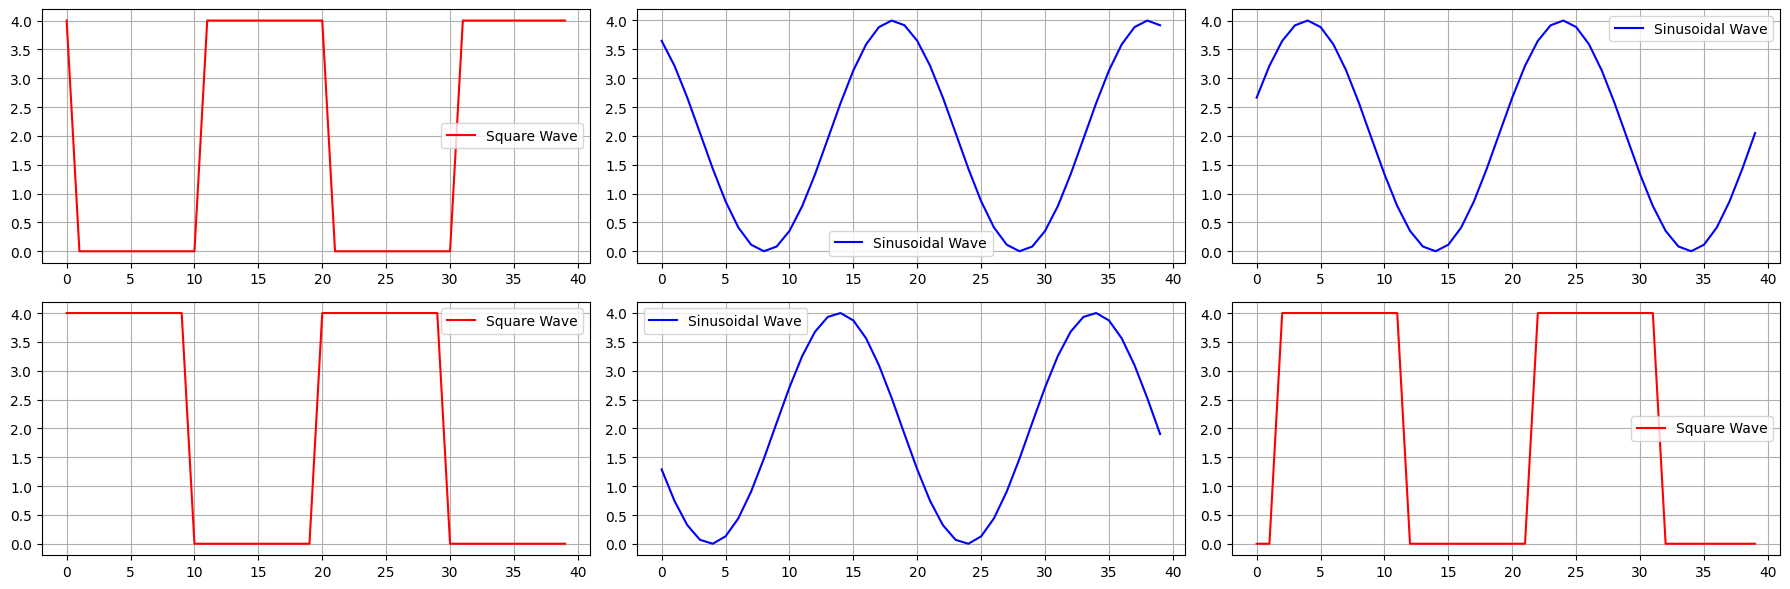

In [13]:
# Function to plot sample waves
def plot_wave(data_loader, num_plots=6, sample_rate=sample_rate, deltaT=deltaT, save_path=None):
    data_iter = iter(data_loader)
    waves, labels = next(data_iter)  # Get one batch of data

    plt.figure(figsize=(18, 6))
    #plt.title(f"Sample rate: {sample_rate} Hz || Delta T: {1000*deltaT:1f} ms")
    for i in range(num_plots):
        plt.subplot(2, 3, i + 1)
        color = 'b' if labels[i] == 0 else 'r'
        plt.plot(waves[i].numpy(), label=f"{'Sinusoidal' if labels[i] == 0 else 'Square'} Wave", color=color)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()
# Visualize sample waves
plot_wave(train_loader, save_path=os.path.join(unique_folder_name, 'wave_samples.png'))

### Accuracy and Loss Results

Test Loss: 0.0073
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Confusion Matrix:
[[50  0]
 [ 0 50]]


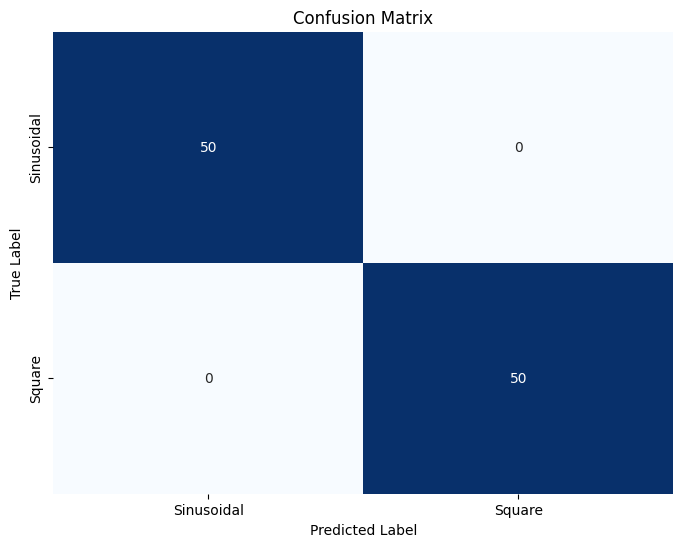

In [14]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for waves, labels in test_loader:
            waves, labels = waves.to(device).float(), labels.to(device).long()
            spk1_rec, mem1_rec, spk2_rec, mem2_rec, _, _ = model(waves)
            loss = criterion(spk2_rec.sum(dim=0), labels)
            running_loss += loss.item()
            
            predicted = spk2_rec.sum(dim=0).argmax(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_test_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    confusion = confusion_matrix(all_labels, all_predictions)

    return {
        'Test Loss': avg_test_loss,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': confusion
    }

def plot_confusion_matrix(confusion):
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap='Blues', cbar=False, xticklabels=['Sinusoidal', 'Square'], yticklabels=['Sinusoidal', 'Square'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


# Calculate metrics for the model
metrics = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {metrics['Test Loss']:.4f}")             # Indicates how well the model is performing on the test data.
print(f"Accuracy: {metrics['Accuracy']:.2f}%")              # Indicates the percentage of correctly classified samples out of the total samples.
print(f"Precision: {metrics['Precision']:.2f}")             # Indicates the ratio of correctly predicted positive observations to the total predicted positives.
print(f"Recall: {metrics['Recall']:.2f}")                   # Indicates the ratio of correctly predicted positive observations to the total actual positives.
print(f"F1 Score: {metrics['F1 Score']:.2f}")               # Indicates the weighted average of the precision and recall.
print(f"Confusion Matrix:\n{metrics['Confusion Matrix']}")  # Indicates the number of true positive, true negative, false positive, and false negative predictions.

plot_confusion_matrix(metrics['Confusion Matrix'])

In [15]:
# Function to plot accuracies using Matplotlib
def plot_accuracies_matplotlib(num_epochs, test_accuracies, validation_accuracies, unique_folder_name):
    sns.set_style('whitegrid')
    plt.figure(figsize=(14, 6))
    cmap = plt.get_cmap('bwr')(np.linspace(0.1, 0.9, 2))
    plt.plot(range(num_epochs), test_accuracies, label='Test Accuracy', color=cmap[1])
    plt.plot(range(num_epochs), validation_accuracies, label='Validation Accuracy', color=cmap[0])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation and Test Accuracy over Epochs')
    plt.ylim(1, 100)
    plt.xlim(0, num_epochs)
    plt.legend(shadow=True)
    sns.despine()
    plt.tight_layout()
    plt.savefig(os.path.join(unique_folder_name, 'accuracy_plot.png'), dpi=600)
    plt.close()
# Function to plot accuracies using Plotly
def plot_accuracies_plotly(num_epochs, test_accuracies, validation_accuracies, unique_folder_name):
    fig_plotly = go.Figure()

    fig_plotly.add_trace(go.Scatter(
        x=list(range(num_epochs)),
        y=test_accuracies,
        mode='lines',
        name='Test Accuracy',
        line=dict(color='red')
    ))

    fig_plotly.add_trace(go.Scatter(
        x=list(range(num_epochs)),
        y=validation_accuracies,
        mode='lines',
        name='Validation Accuracy',
        line=dict(color='blue')
    ))

    fig_plotly.update_layout(
        title='Validation and Test Accuracy over Epochs',
        xaxis_title='Epochs',
        xaxis=dict(range=[0, num_epochs]),
        yaxis_title='Accuracy (%)',
        yaxis=dict(range=[1, 100]),
        legend=dict(x=0, y=1, traceorder='normal'),
        template='plotly_white'
    )
    fig_plotly.show()
    pio.write_html(fig_plotly, file=os.path.join(unique_folder_name, 'interactive_accuracy_plot.html'))
# Plot accuracies
plot_accuracies_matplotlib(num_epochs, test_accuracies, validation_accuracies, unique_folder_name)
plot_accuracies_plotly(num_epochs, test_accuracies, validation_accuracies, unique_folder_name)

In [16]:
# Function to plot loss curves using Matplotlib
def plot_loss_curve(train_losses, validation_losses, num_epochs, save_path=None):
    epochs = np.arange(num_epochs)
    plt.figure(figsize=(14, 6))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.legend()
    if save_path:
        plt.savefig(save_path, dpi=600)
    plt.close()
# Function to plot loss curves using Plotly
def plot_interactive_loss_curve(train_losses, validation_losses, num_epochs, save_path=None):
    fig_plotly = go.Figure()

    fig_plotly.add_trace(go.Scatter(
        x=list(range(num_epochs)),
        y=train_losses,
        mode='lines',
        name='Training Loss',
        line=dict(color='blue')
    ))

    fig_plotly.add_trace(go.Scatter(
        x=list(range(num_epochs)),
        y=validation_losses,
        mode='lines',
        name='Validation Loss',
        line=dict(color='red')
    ))

    fig_plotly.update_layout(
        title='Training and Validation Loss over Epochs',
        xaxis_title='Epochs',
        xaxis=dict(range=[0, num_epochs]),
        yaxis_title='Loss',
        template='plotly_white'
    )

    fig_plotly.show()
    
    if save_path:
        pio.write_html(fig_plotly, file=save_path)
# Plot loss curves
plot_loss_curve(loss_hist, test_loss_hist, num_epochs, save_path=os.path.join(unique_folder_name, 'loss_curve.png'))
plot_interactive_loss_curve(loss_hist, test_loss_hist, num_epochs, save_path=os.path.join(unique_folder_name, 'interactive_loss_curve.html'))

In [17]:
# Function to plot beta values using Matplotlib
def plot_equal_prediction_values(equal_prediction_values, num_epochs, save_path=None):
    plt.figure(figsize=(14, 6))
    plt.plot(range(num_epochs), equal_prediction_values, label='Equal Prediction Count', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Count')
    plt.title('Equal Prediction Count over Epochs')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600)
    plt.close()
# Function to plot no prediction and equal prediction values using Plotly
def plot_interactive_equal_prediction_values(equal_prediction_values, num_epochs, save_path=None):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=list(range(num_epochs)),
        y=equal_prediction_values,
        mode='lines',
        name='Equal Prediction Count',
        line=dict(color='blue')
    ))

    fig.update_layout(
        title='Equal Prediction Count over Epochs',
        xaxis_title='Epochs',
        yaxis_title='Count',
        template='plotly_white',
        legend=dict(x=0, y=1, traceorder='normal')
    )

    fig.show()
    if save_path:
        pio.write_html(fig, file=save_path)
# Plot no prediction and equal prediction values
plot_equal_prediction_values(equal_prediction_values, num_epochs, save_path=os.path.join(unique_folder_name, 'equal_prediction_values.png'))
plot_interactive_equal_prediction_values(equal_prediction_values, num_epochs, save_path=os.path.join(unique_folder_name, 'interactive_equal_prediction_values.html'))

### Beta values

In [18]:
# Function to plot beta values of hidden layer using Matplotlib
def plot_beta_values_matplotlib(beta1_values, num_epochs, unique_folder_name):
    beta1_values = np.array(beta1_values)
    plt.figure(figsize=(14, 6))
    for i in range(beta1_values.shape[1]):
        plt.plot(range(num_epochs), beta1_values[:, i])
    plt.xlabel('Epochs')
    plt.ylabel(r'beta hidden layer')
    plt.title(r'beta values (hidden layer) over Epochs')
    plt.ylim(0.001, 1)
    plt.xlim(0, num_epochs)
    plt.grid(True)
    plt.savefig(os.path.join(unique_folder_name, 'beta_hidden_layer.png'), dpi=600)
    plt.close()
# Function to plot beta values of hidden layer using Plotly
def plot_beta_values_plotly(beta1_values, num_epochs, unique_folder_name):
    beta1_values = np.array(beta1_values)  # Convert to NumPy array
    fig_beta_hidden = go.Figure()
    for i in range(beta1_values.shape[1]):
        fig_beta_hidden.add_trace(go.Scatter(
            x=list(range(num_epochs)),
            y=beta1_values[:, i],
            mode='lines',
            name=f'Neuron {i}'
        ))
    fig_beta_hidden.update_layout(
        title=r'beta values (hidden layer) over Epochs',
        xaxis_title='Epochs',
        xaxis=dict(range=[0, num_epochs]),
        yaxis_title=r'beta hidden layer',
        yaxis=dict(range=[0.001, 1]),
        template='plotly_white'
    )
    pio.write_html(fig_beta_hidden, file=os.path.join(unique_folder_name, 'interactive_beta_hidden_layer.html'))
    fig_beta_hidden.show()
# Plot beta values of hidden layer
plot_beta_values_matplotlib(beta1_values, num_epochs, unique_folder_name)
#plot_beta_values_plotly(beta1_values, num_epochs, unique_folder_name)

In [19]:
# Function to plot beta values of output layer using Matplotlib
def plot_beta_output_matplotlib(beta2_values, num_epochs, unique_folder_name):
    beta2_values = np.array(beta2_values)
    plt.figure(figsize=(14, 6))
    for i in range(beta2_values.shape[1]):
        plt.plot(range(num_epochs), beta2_values[:, i], label=f'Neuron {i}')
    plt.xlabel('Epochs')
    plt.ylabel(r'beta output layer')
    plt.title(r'beta values (output layer) over Epochs')
    plt.ylim(0.001, 1)
    plt.xlim(0, num_epochs)
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(unique_folder_name, 'beta_output_layer.png'), dpi=600)
    plt.close()
# Function to plot beta values of output layer using Plotly
def plot_beta_output_plotly(beta2_values, num_epochs, unique_folder_name):
    beta2_values = np.array(beta2_values)
    fig_beta_output = go.Figure()
    for i in range(beta2_values.shape[1]):
        fig_beta_output.add_trace(go.Scatter(
            x=list(range(num_epochs)),
            y=beta2_values[:, i],
            mode='lines',
            name=f'Neuron {i}'
        ))
    fig_beta_output.update_layout(
        title=r'beta values (output layer) over Epochs',
        xaxis_title='Epochs',
        xaxis=dict(range=[0, num_epochs]),
        yaxis_title=r'beta output layer',
        yaxis=dict(range=[0.001, 1]),
        template='plotly_white'
    )
    pio.write_html(fig_beta_output, file=os.path.join(unique_folder_name, 'interactive_beta_output_layer.html'))
    fig_beta_output.show()
# Plot beta values of output layer
plot_beta_output_matplotlib(beta2_values, num_epochs, unique_folder_name)
#plot_beta_output_plotly(beta2_values, num_epochs, unique_folder_name)

In [20]:
# Function to plot histograms of beta values for hidden and output layer neurons
def plot_beta_histograms(model, unique_folder_name):
    beta_hidden = model.lif1.beta.detach().numpy()
    beta_output = model.lif2.beta.detach().numpy()

    max_beta_value = max(beta_hidden.max(), beta_output.max())
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

    # Histogram of beta values for hidden layer neurons
    axs[0].hist(beta_hidden, alpha=0.8, color='blue')
    axs[0].set_xlabel(r'$\beta$ values')
    axs[0].set_xlim(0.001, 1 if max_beta_value > 1 else max_beta_value)
    axs[0].set_ylabel('Frequency')
    axs[0].set_title(r'Histogram of $\beta$ values for hidden layer neurons')

    # Histogram of beta values for output layer neurons
    axs[1].hist(beta_output, alpha=0.8, color='blue')
    axs[1].set_xlabel(r'$\beta$ values')
    axs[1].set_xlim(0.001, 1 if max_beta_value > 1 else max_beta_value)
    axs[1].set_ylabel('Frequency')
    axs[1].set_title(r'Histogram of $\beta$ values for output layer neurons')

    plt.tight_layout()
    plt.savefig(os.path.join(unique_folder_name, 'beta_histograms.png'), dpi=600)
    plt.show()
    plt.close()
# Plot histograms of beta values for hidden and output layer neurons
#plot_beta_histograms(model, unique_folder_name)

### Tau plots

In [21]:
# Function to plot tau values of hidden layer using Matplotlib
def plot_tau_hidden_matplotlib(beta1_values, num_epochs, deltaT, unique_folder_name):
    beta1_values = np.array(beta1_values)
    plt.figure(figsize=(14, 6))
    for i in range(beta1_values.shape[1]):
        plt.plot(range(num_epochs), -1000 * deltaT / np.log(beta1_values[:, i]))
    plt.xlabel('Epochs')
    plt.ylabel(r'tau hidden layer [ms]')
    plt.xlim(0, num_epochs)
    plt.ylim(0.001, None)
    plt.title(f'Hidden layer tau values over Epochs (deltaT = {deltaT}ms)')
    plt.grid(True)
    plt.savefig(os.path.join(unique_folder_name, 'tau_hidden_layer.png'), dpi=600)
    plt.close()
# Function to plot tau values of hidden layer using Plotly
def plot_tau_hidden_plotly(beta1_values, num_epochs, deltaT, unique_folder_name):
    beta1_values = np.array(beta1_values)
    fig_tau_hidden = go.Figure()
    for i in range(beta1_values.shape[1]):
        fig_tau_hidden.add_trace(go.Scatter(
            x=list(range(num_epochs)),
            y=-1000 * deltaT / np.log(beta1_values[:, i]),
            mode='lines',
            name=f'Neuron {i}'
        ))
    fig_tau_hidden.update_layout(
        title=f'Hidden layer tau values over Epochs (deltaT = {1000*deltaT}ms)',
        xaxis_title='Epochs',
        xaxis=dict(range=[0, num_epochs]),
        yaxis=dict(range=[0.1, None]),
        yaxis_title=r'tau hidden layer [ms]',
        template='plotly_white'
    )
    pio.write_html(fig_tau_hidden, file=os.path.join(unique_folder_name, 'interactive_tau_hidden_layer.html'))
    fig_tau_hidden.show()
# Plot tau values of hidden layer
plot_tau_hidden_matplotlib(beta1_values, num_epochs, deltaT, unique_folder_name)
plot_tau_hidden_plotly(beta1_values, num_epochs, deltaT, unique_folder_name)

In [22]:
# Function to plot tau values of output layer using Matplotlib
def plot_tau_output_matplotlib(beta2_values, num_epochs, deltaT, unique_folder_name):
    beta2_values = np.array(beta2_values)
    plt.figure(figsize=(14, 6))
    for i in range(beta2_values.shape[1]):
        plt.plot(range(num_epochs), -1000 * deltaT / np.log(beta2_values[:, i]))
    plt.xlabel('Epochs')
    plt.ylabel(r'tau output layer [ms]')
    plt.xlim(0, num_epochs)
    plt.ylim(0.001, None)
    plt.title(f'Output layer tau values over Epochs (deltaT = {1000*deltaT}ms)')
    plt.grid(True)
    plt.savefig(os.path.join(unique_folder_name, 'tau_output_layer.png'), dpi=600)
    plt.close()
# Function to plot tau values of output layer using Plotly
def plot_tau_output_plotly(beta2_values, num_epochs, deltaT, unique_folder_name):
    beta2_values = np.array(beta2_values)
    fig_tau_output = go.Figure()
    for i in range(beta2_values.shape[1]):
        fig_tau_output.add_trace(go.Scatter(
            x=list(range(num_epochs)),
            y=-1000 * deltaT / np.log(beta2_values[:, i]),
            mode='lines',
            name=f'Neuron {i}'
        ))
    fig_tau_output.update_layout(
        title=f'Output layer tau values over Epochs (deltaT = {1000*deltaT}ms)',
        xaxis_title='Epochs',
        xaxis=dict(range=[0, num_epochs]),
        yaxis=dict(range=[0.1, None]),
        yaxis_title=r'tau output layer [ms]',
        template='plotly_white'
    )
    pio.write_html(fig_tau_output, file=os.path.join(unique_folder_name, 'interactive_tau_output_layer.html'))
    fig_tau_output.show()
# Plot tau values of output layer
plot_tau_output_matplotlib(beta2_values, num_epochs, deltaT, unique_folder_name)
plot_tau_output_plotly(beta2_values, num_epochs, deltaT, unique_folder_name)

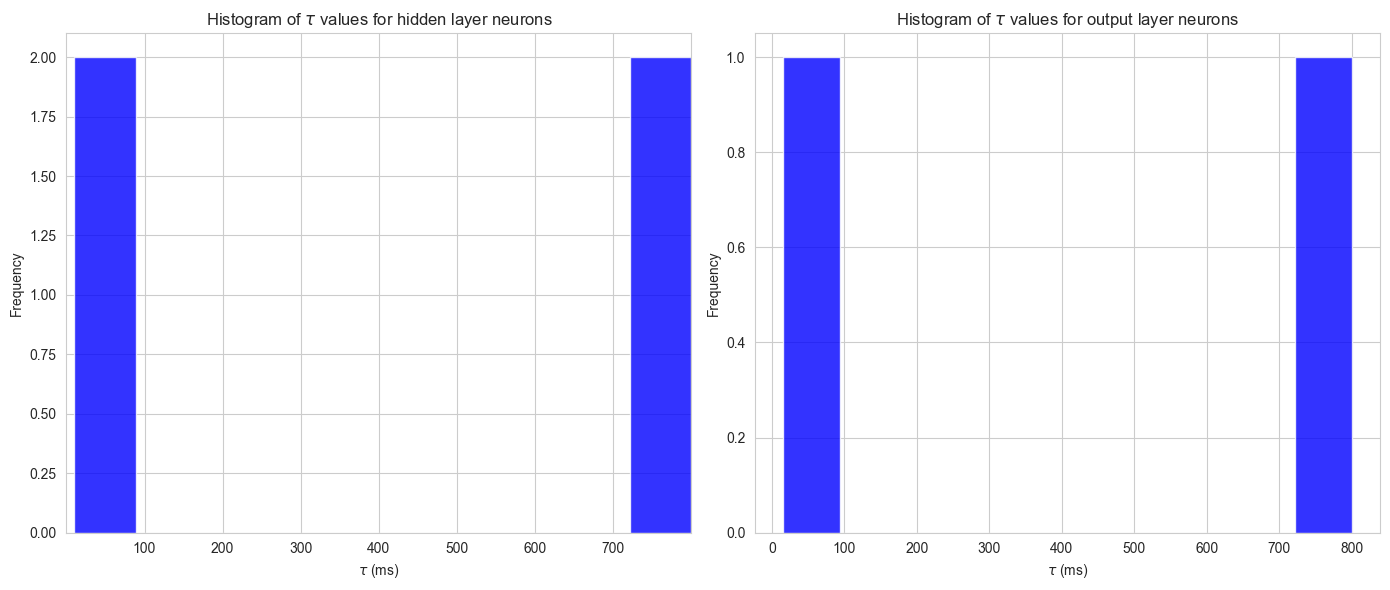

In [23]:
# Function to plot histograms of tau values for hidden and output layer neurons
def plot_tau_histograms(model, deltaT, unique_folder_name):
    tau_hidden = -1000 * deltaT / np.log(model.lif1.beta.detach().numpy())
    tau_output = -1000 * deltaT / np.log(model.lif2.beta.detach().numpy())

    max_tau_value = max(tau_hidden.max(), tau_output.max())
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

    # Histogram of tau values for hidden layer neurons
    axs[0].hist(tau_hidden, alpha=0.8, color='blue')
    axs[0].set_xlabel(r'$\tau$ (ms)')
    axs[0].set_ylabel('Frequency')
    axs[0].set_xlim(0.001, max_tau_value)
    axs[0].set_title(r'Histogram of $\tau$ values for hidden layer neurons')

    # Histogram of tau values for output layer neurons
    axs[1].hist(tau_output, alpha=0.8, color='blue')
    axs[1].set_xlabel(r'$\tau$ (ms)')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title(r'Histogram of $\tau$ values for output layer neurons')

    plt.tight_layout()
    plt.savefig(os.path.join(unique_folder_name, 'tau_histograms.png'), dpi=600)
    plt.show()
    plt.close()
# Plot histograms of tau values for hidden and output layer neurons
plot_tau_histograms(model, deltaT, unique_folder_name)

### Weights plots

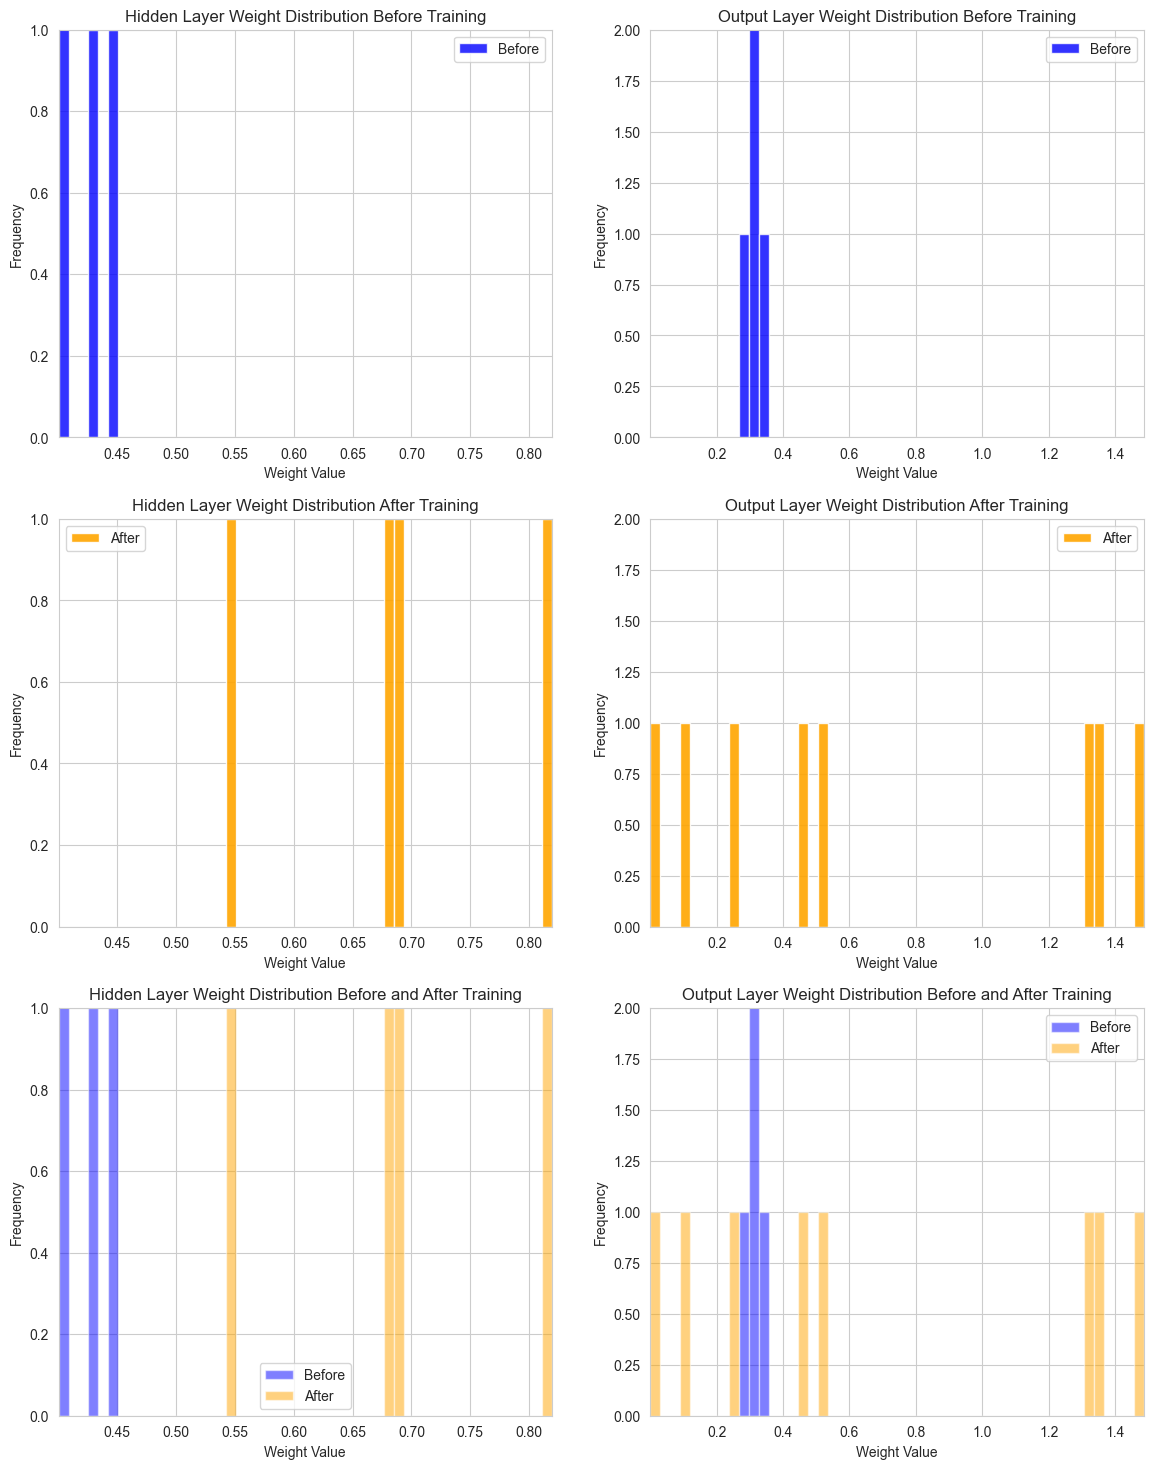

In [24]:
# Function to plot weight distributions before and after training
def plot_weight_distribution_before_after(weights_before, weights_after, unique_folder_name):
    fig, axs = plt.subplots(3, 2, figsize=(14, 18))

    # Determine the x and y axis limits for hidden layer
    hidden_x_max = max(np.abs(weights_before[0]).max(), np.abs(weights_after[0]).max())
    hidden_y_max = max(np.histogram(weights_before[0].flatten(), bins=50)[0].max(),
                       np.histogram(weights_after[0].flatten(), bins=50)[0].max())
    hidden_x_min = min(np.abs(weights_before[0]).min(), np.abs(weights_after[0]).min())
    hidden_y_min = min(np.histogram(weights_before[0].flatten(), bins=50)[0].min(),
                       np.histogram(weights_after[0].flatten(), bins=50)[0].min())

    # Determine the x and y axis limits for output layer
    output_x_max = max(np.abs(weights_before[1]).max(), np.abs(weights_after[1]).max())
    output_y_max = max(np.histogram(weights_before[1].flatten(), bins=50)[0].max(),
                       np.histogram(weights_after[1].flatten(), bins=50)[0].max())
    output_x_min = min(np.abs(weights_before[1]).min(), np.abs(weights_after[1]).min())
    output_y_min = min(np.histogram(weights_before[1].flatten(), bins=50)[0].min(),
                       np.histogram(weights_after[1].flatten(), bins=50)[0].min())

    # Define the bins
    hidden_bins = np.linspace(hidden_x_min, hidden_x_max, 51)  # 50 bins
    output_bins = np.linspace(output_x_min, output_x_max, 51)  # 50 bins

    # Plot before training for hidden layer
    axs[0, 0].hist(weights_before[0].flatten(), bins=hidden_bins, alpha=0.8, color='blue', label='Before')
    axs[0, 0].set_xlabel('Weight Value')
    axs[0, 0].set_ylabel('Frequency')
    axs[0, 0].set_title('Hidden Layer Weight Distribution Before Training')
    axs[0, 0].set_xlim(hidden_x_min, hidden_x_max)
    axs[0, 0].set_ylim(hidden_y_min, hidden_y_max)
    axs[0, 0].legend()

    # Plot before training for output layer
    axs[0, 1].hist(weights_before[1].flatten(), bins=output_bins, alpha=0.8, color='blue', label='Before')
    axs[0, 1].set_xlabel('Weight Value')
    axs[0, 1].set_ylabel('Frequency')
    axs[0, 1].set_title('Output Layer Weight Distribution Before Training')
    axs[0, 1].set_xlim(output_x_min, output_x_max)
    axs[0, 1].set_ylim(output_y_min, output_y_max)
    axs[0, 1].legend()

    # Plot after training for hidden layer
    axs[1, 0].hist(weights_after[0].flatten(), bins=hidden_bins, alpha=0.9, color='orange', label='After')
    axs[1, 0].set_xlabel('Weight Value')
    axs[1, 0].set_ylabel('Frequency')
    axs[1, 0].set_title('Hidden Layer Weight Distribution After Training')
    axs[1, 0].set_xlim(hidden_x_min, hidden_x_max)
    axs[1, 0].set_ylim(hidden_y_min, hidden_y_max)
    axs[1, 0].legend()

    # Plot after training for output layer
    axs[1, 1].hist(weights_after[1].flatten(), bins=output_bins, alpha=0.9, color='orange', label='After')
    axs[1, 1].set_xlabel('Weight Value')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].set_title('Output Layer Weight Distribution After Training')
    axs[1, 1].set_xlim(output_x_min, output_x_max)
    axs[1, 1].set_ylim(output_y_min, output_y_max)
    axs[1, 1].legend()

    # Overlay plot for hidden layer
    axs[2, 0].hist(weights_before[0].flatten(), bins=hidden_bins, alpha=0.5, color='blue', label='Before')
    axs[2, 0].hist(weights_after[0].flatten(), bins=hidden_bins, alpha=0.5, color='orange', label='After')
    axs[2, 0].set_xlabel('Weight Value')
    axs[2, 0].set_ylabel('Frequency')
    axs[2, 0].set_title('Hidden Layer Weight Distribution Before and After Training')
    axs[2, 0].set_xlim(hidden_x_min, hidden_x_max)
    axs[2, 0].set_ylim(hidden_y_min, hidden_y_max)
    axs[2, 0].legend()

    # Overlay plot for output layer
    axs[2, 1].hist(weights_before[1].flatten(), bins=output_bins, alpha=0.5, color='blue', label='Before')
    axs[2, 1].hist(weights_after[1].flatten(), bins=output_bins, alpha=0.5, color='orange', label='After')
    axs[2, 1].set_xlabel('Weight Value')
    axs[2, 1].set_ylabel('Frequency')
    axs[2, 1].set_title('Output Layer Weight Distribution Before and After Training')
    axs[2, 1].set_xlim(output_x_min, output_x_max)
    axs[2, 1].set_ylim(output_y_min, output_y_max)
    axs[2, 1].legend()

    plt.savefig(os.path.join(unique_folder_name, 'weights_distribution_before_after.png'), dpi=600)
    plt.show()
# Plot weight distributions before and after training
weights_before = [weights_hidden_layer[0], weights_output_layer[0]]
weights_after = [weights_hidden_layer[-1], weights_output_layer[-1]]
plot_weight_distribution_before_after(weights_before, weights_after, unique_folder_name)

In [25]:
# Function to plot hidden layer weights over epochs using Matplotlib
def plot_hidden_layer_weights_matplotlib(weights_hidden_layer, num_epochs, unique_folder_name):
    plt.figure(figsize=(14, 6))
    weights_hidden_layer_np = np.array(weights_hidden_layer)
    num_neurons = weights_hidden_layer_np.shape[1]  # Number of hidden layer neurons
    for i in range(num_neurons):
        plt.plot(range(num_epochs), weights_hidden_layer_np[:, i, :].flatten(), label=f'Neuron {i}')
    plt.xlabel('Epochs')
    plt.ylabel('Hidden Layer Weights')
    plt.xlim(0, num_epochs)
    plt.title('Hidden Layer Weights over Epochs')
    plt.grid(True)
    plt.legend()
    plt.savefig(os.path.join(unique_folder_name, 'weights_hidden_layer.png'), dpi=600)
    plt.close()
# Function to plot hidden layer weights over epochs using Plotly
def plot_hidden_layer_weights_plotly(weights_hidden_layer, num_epochs, unique_folder_name):
    weights_hidden_layer_np = np.array(weights_hidden_layer)
    fig_weights_hidden = go.Figure()
    num_neurons = weights_hidden_layer_np.shape[1]  # Number of hidden layer neurons
    for i in range(num_neurons):
        fig_weights_hidden.add_trace(go.Scatter(
            x=list(range(num_epochs)),
            y=weights_hidden_layer_np[:, i, :].flatten(),
            mode='lines',
            name=f'Neuron {i}'
        ))
    fig_weights_hidden.update_layout(
        title='Hidden Layer Weights over Epochs',
        xaxis_title='Epochs',
        xaxis=dict(range=[0, num_epochs]),
        yaxis_title='Hidden Layer Weights',
        template='plotly_white'
    )
    pio.write_html(fig_weights_hidden, file=os.path.join(unique_folder_name, 'interactive_weights_hidden_layer.html'))
    fig_weights_hidden.show()
# Plot hidden layer weights over epochs
plot_hidden_layer_weights_matplotlib(weights_hidden_layer, num_epochs, unique_folder_name)
plot_hidden_layer_weights_plotly(weights_hidden_layer, num_epochs, unique_folder_name)

In [26]:
# Function to plot output layer weights over epochs using Matplotlib
def plot_output_layer_weights_matplotlib(weights_output_layer, num_epochs, unique_folder_name):
    plt.figure(figsize=(14, 6))
    weights_output_layer_np = np.array(weights_output_layer)
    num_neurons = weights_output_layer_np.shape[2]  # Number of output layer neurons
    for i in range(num_neurons):
        plt.plot(range(num_epochs), weights_output_layer_np[:, 0, i], label=f'Neuron {i}')
    plt.xlabel('Epochs')
    plt.xlim(0, num_epochs)
    plt.ylabel('Output Layer Weights')
    plt.title('Output Layer Weights over Epochs')
    plt.grid(True)
    plt.legend()
    plt.savefig(os.path.join(unique_folder_name, 'weights_output_layer.png'), dpi=600)
    plt.close()
# Function to plot output layer weights over epochs using Plotly
def plot_output_layer_weights_plotly(weights_output_layer, num_epochs, unique_folder_name):
    weights_output_layer_np = np.array(weights_output_layer)
    fig_weights_output = go.Figure()
    num_neurons = weights_output_layer_np.shape[2]  # Number of output layer neurons
    for i in range(num_neurons):
        fig_weights_output.add_trace(go.Scatter(
            x=list(range(num_epochs)),
            y=weights_output_layer_np[:, 0, i],
            mode='lines',
            name=f'Neuron {i}'
        ))
    fig_weights_output.update_layout(
        title='Output Layer Weights over Epochs',
        xaxis_title='Epochs',
        xaxis=dict(range=[0, num_epochs]),
        yaxis_title='Output Layer Weights',
        template='plotly_white'
    )
    pio.write_html(fig_weights_output, file=os.path.join(unique_folder_name, 'interactive_weights_output_layer.html'))
    fig_weights_output.show()
# Plot output layer weights over epochs
plot_output_layer_weights_matplotlib(weights_output_layer, num_epochs, unique_folder_name)
plot_output_layer_weights_plotly(weights_output_layer, num_epochs, unique_folder_name)

### Spike Plots

In [27]:
# Function to plot spike counts using Matplotlib
def plot_spike_counts_matplotlib(hidden_spike_count, output_spike_count, num_epochs, unique_folder_name):
    plt.figure(figsize=(14, 6))
    
    # Plot hidden spike counts
    plt.plot(range(num_epochs), hidden_spike_count, label='Hidden Layer Spike Count', color='blue')
    
    # Plot output spike counts
    plt.plot(range(num_epochs), output_spike_count, label='Output Layer Spike Count', color='orange')
    
    plt.xlabel('Epochs')
    plt.ylabel('Average Spike Count')
    plt.title('Spike Counts over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.savefig(os.path.join(unique_folder_name, 'spike_counts.png'), dpi=600)
    plt.close()
# Function to plot spike counts using Plotly
def plot_spike_counts_plotly(hidden_spike_count, output_spike_count, num_epochs, unique_folder_name):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=list(range(num_epochs)),
        y=hidden_spike_count,
        mode='lines',
        name='Hidden Layer Spike Count',
        line=dict(color='blue')
    ))

    fig.add_trace(go.Scatter(
        x=list(range(num_epochs)),
        y=output_spike_count,
        mode='lines',
        name='Output Layer Spike Count',
        line=dict(color='orange')
    ))

    fig.update_layout(
        title='Spike Counts over Epochs',
        xaxis_title='Epochs',
        yaxis_title='Average Spike Count',
        template='plotly_white',
        legend=dict(x=0, y=1, traceorder='normal')
    )

    fig.show()
    pio.write_html(fig, file=os.path.join(unique_folder_name, 'interactive_spike_counts.html'))
# Plot spike counts
plot_spike_counts_matplotlib(hidden_spike_count, output_spike_count, num_epochs, unique_folder_name)
plot_spike_counts_plotly(hidden_spike_count, output_spike_count, num_epochs, unique_folder_name)

In [28]:
# Function to plot spike counts using Matplotlib
def plot_spike_counts(hidden_spike_count, output_spike_count, output_spike_counts_neuron0, output_spike_counts_neuron1, num_epochs, save_path=None):
    plt.figure(figsize=(14, 6))
    
    # Plot hidden spike counts
    plt.plot(range(num_epochs), hidden_spike_count, label='Hidden Layer Spike Count', color='blue')
    
    # Plot output spike counts
    plt.plot(range(num_epochs), output_spike_count, label='Output Layer Spike Count (average)', color='orange')

    # Plot output neuron 0 spike counts
    plt.plot(range(num_epochs), output_spike_counts_neuron0, label='Output Layer Neuron 0 Spike Count', color='green')

    # Plot output neuron 1 spike counts
    plt.plot(range(num_epochs), output_spike_counts_neuron1, label='Output Layer Neuron 1 Spike Count', color='red')
    
    plt.xlabel('Epochs')
    plt.ylabel('Average Spike Count')
    plt.title('Spike Counts over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=600)
    plt.close()
#plot_spike_counts(hidden_spike_count, output_spike_count, output_spike_counts_neuron0, output_spike_counts_neuron1, num_epochs, save_path=os.path.join(unique_folder_name, 'spike_counts.png'))
# Function to plot spike counts using Plotly
def plot_interactive_spike_counts(hidden_spike_count, output_spike_count, output_spike_counts_neuron0, output_spike_counts_neuron1, num_epochs, save_path=None):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=list(range(num_epochs)),
        y=hidden_spike_count,
        mode='lines',
        name='Hidden Layer Spike Count',
        line=dict(color='blue')
    ))

    fig.add_trace(go.Scatter(
        x=list(range(num_epochs)),
        y=output_spike_count,
        mode='lines',
        name='Output Layer Spike Count (Total)',
        line=dict(color='orange')
    ))

    fig.add_trace(go.Scatter(
        x=list(range(num_epochs)),
        y=output_spike_counts_neuron0,
        mode='lines',
        name='Output Layer Neuron 0 Spike Count',
        line=dict(color='green')
    ))

    fig.add_trace(go.Scatter(
        x=list(range(num_epochs)),
        y=output_spike_counts_neuron1,
        mode='lines',
        name='Output Layer Neuron 1 Spike Count',
        line=dict(color='red')
    ))

    fig.update_layout(
        title='Spike Counts over Epochs',
        xaxis_title='Epochs',
        yaxis_title='Average Spike Count',
        template='plotly_white',
        legend=dict(x=0, y=1, traceorder='normal')
    )

    fig.show()
    
    if save_path:
        pio.write_html(fig, file=save_path)
# Plot interactive spike counts
#plot_interactive_spike_counts(hidden_spike_count, output_spike_count, output_spike_counts_neuron0, output_spike_counts_neuron1, num_epochs, save_path=os.path.join(unique_folder_name, 'interactive_spike_counts.html'))

In [29]:
def plot_snn_spikes(spk1_rec, spk2_rec, title, save_path=None):
    fig, axs = plt.subplots(2, figsize=(14, 8), sharex=True)
    
    def raster_with_dots(spikes, ax, color, label):
        for i in range(spikes.shape[1]):
            spk_times = np.where(spikes[:, i].detach().cpu().numpy())[0]
            ax.scatter(spk_times, np.full_like(spk_times, i), s=3, color=color, label=label if i == 0 else "")  # Add label only once

    raster_with_dots(spk1_rec, axs[0], 'tab:orange', '')
    axs[0].set_title('Hidden Layer Spikes')
    axs[0].set_ylabel('Batch Samples')
    #axs[0].legend()

    raster_with_dots(spk2_rec[:, :, 0], axs[1], 'tab:orange', '')
    raster_with_dots(spk2_rec[:, :, 1], axs[1], 'tab:blue', '')
    axs[1].set_title('Output Layer Spikes')
    axs[1].set_ylabel('Batch Samples')
    axs[1].set_xlabel('Time Steps')
    #axs[1].legend()

    plt.suptitle(title)
    if save_path:
        plt.savefig(save_path)
    plt.show()
# # Visualize the spiking activity of the network
# waves, labels = next(iter(test_loader))
# waves, labels = waves.to(device).float(), labels.to(device).long()
# spk1_rec, mem1_rec, spk2_rec, mem2_rec, hidden_spike_count, output_spike_count = model(waves)
# Plot hidden and output layer spikes
#plot_snn_spikes(spk1_rec, spk2_rec, "Spike Count of Fully Connected Spiking Neural Network", save_path=os.path.join(unique_folder_name, 'snn_spikes.png'))

In [30]:
# Function to plot hidden layer spikes using Plotly
def plot_snn_hidden_spikes_plotly(model, test_loader, device, unique_folder_name):

    waves, labels = next(iter(test_loader))
    waves, labels = waves.to(device).float(), labels.to(device).long()
    spk1_rec, mem1_rec, spk2_rec, mem2_rec, hidden_spike_count, output_spike_count = model(waves)

    fig_hidden = go.Figure()

    def raster_with_dots(spikes, fig, label_colors):
        sizes = 6
        for i in range(spikes.shape[1]):
            spk_times = np.where(spikes[:, i].detach().cpu().numpy())[0]
            for t in spk_times:
                fig.add_trace(go.Scatter(
                    x=[t],
                    y=[i],
                    mode='markers',
                    marker=dict(color=label_colors[i], size=sizes, symbol='circle'),
                    name=f'Hidden Layer Neuron {i}' if t == spk_times[0] else ''
                ))

    # Assign colors based on the input wave type
    label_colors = ['blue' if label == 0 else 'orange' for label in labels]

    # Map label colors to the corresponding spike times
    spike_color_map = []
    for t in range(spk1_rec.shape[0]):
        spike_color_map.append(label_colors[t % len(labels)])

    raster_with_dots(spk1_rec, fig_hidden, spike_color_map)
    
    fig_hidden.update_layout(
        title='Hidden Layer Spikes',
        xaxis_title='Time Steps',
        yaxis_title='Batch Samples',
        template='plotly_white',
        showlegend=False  # Hide the default legend
    )

    # Add custom legend as text annotations
    fig_hidden.add_annotation(
        text='- Sine wave: blue <br>- Square wave: orange',
        xref='paper', yref='paper',
        x=0.5, y=1.1,
        showarrow=False,
        font=dict(size=12)
    )

    fig_hidden.show()
    pio.write_html(fig_hidden, file=os.path.join(unique_folder_name, 'interactive_hidden_layer_spikes.html'))
# Plot hidden layer spikes
plot_snn_hidden_spikes_plotly(model, test_loader, device, unique_folder_name)

In [31]:
# Function to plot output layer spikes using Plotly
def plot_snn_output_spikes_plotly(model, test_loader, device, unique_folder_name):

    waves, labels = next(iter(test_loader))
    waves, labels = waves.to(device).float(), labels.to(device).long()
    spk1_rec, mem1_rec, spk2_rec, mem2_rec, hidden_spike_count, output_spike_count = model(waves)

    fig_output = go.Figure()

    def raster_with_dots(spikes_0, spikes_1, fig, label_colors_0, label_colors_1, label_prefix_0, label_prefix_1):
        sizes = 6
        for i in range(spikes_0.shape[1]):
            spk_times_0 = np.where(spikes_0[:, i].detach().cpu().numpy())[0]
            spk_times_1 = np.where(spikes_1[:, i].detach().cpu().numpy())[0]

            # Plot spikes for neuron 0
            for t in spk_times_0:
                if t in spk_times_1:  # Check if neuron 1 spikes at the same time
                    fig.add_trace(go.Scatter(
                        x=[t],
                        y=[i],
                        mode='markers',
                        marker=dict(color='green', size=sizes, symbol='circle'),
                        name='Both Neurons' if t == spk_times_0[0] else ''
                    ))
                else:
                    fig.add_trace(go.Scatter(
                        x=[t],
                        y=[i],
                        mode='markers',
                        marker=dict(color=label_colors_0[i], size=sizes, symbol='circle'),
                        name=f'{label_prefix_0} Neuron {i}' if t == spk_times_0[0] else ''
                    ))

            # Plot spikes for neuron 1 (only those that are not shared with neuron 0)
            for t in spk_times_1:
                if t not in spk_times_0:
                    fig.add_trace(go.Scatter(
                        x=[t],
                        y=[i],
                        mode='markers',
                        marker=dict(color=label_colors_1[i], size=sizes, symbol='cross'),
                        name=f'{label_prefix_1} Neuron {i}' if t == spk_times_1[0] else ''
                    ))

    # Assign colors based on the input wave type
    label_colors_0 = ['blue' if label == 0 else 'black' for label in labels]
    label_colors_1 = ['orange' if label == 0 else 'red' for label in labels]

    # Map label colors to the corresponding spike times
    spike_color_map_0 = []
    spike_color_map_1 = []
    for t in range(spk2_rec.shape[0]):
        spike_color_map_0.append(label_colors_0[t % len(labels)])
        spike_color_map_1.append(label_colors_1[t % len(labels)])

    raster_with_dots(spk2_rec[:, :, 0], spk2_rec[:, :, 1], fig_output, spike_color_map_0, spike_color_map_1, 'Output Neuron 0', 'Output Neuron 1')
    
    fig_output.update_layout(
        title='Output Layer Spikes',
        xaxis_title='Time Steps',
        yaxis_title='Batch Samples',
        template='plotly_white',
        showlegend=False  # Hide the default legend
    )

    # Add custom legend as text annotations
    fig_output.add_annotation(
        text='- Sine wave: neuron 0 (blue) / neuron 1 (orange) / both (green) <br>- Square wave: neuron 0 (black) / neuron 1 (red) / both (green)',
        xref='paper', yref='paper',
        x=0.5, y=1.1,
        showarrow=False,
        font=dict(size=12)
    )

    fig_output.show()
    pio.write_html(fig_output, file=os.path.join(unique_folder_name, 'interactive_output_layer_spikes.html'))
# Plot output layer spikes
plot_snn_output_spikes_plotly(model, test_loader, device, unique_folder_name)

### Membrane threshold plots

In [32]:
threshold_hidden_layer_np = np.array(threshold_hidden_layer)
threshold_output_layer_np = np.array(threshold_output_layer)

# Plotting the membrane threshold potentials of hidden layer vs Epochs
plt.figure(figsize=(14, 6))
for i in range(threshold_hidden_layer_np.shape[1]):
    plt.plot(range(num_epochs), threshold_hidden_layer_np[:, i], label=f'Neuron {i}')
plt.xlabel('Epochs')
plt.ylabel('Hidden Layer Membrane Threshold Potential')
plt.xlim(0, num_epochs)
plt.title('Hidden Layer Membrane Threshold Potentials over Epochs')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(unique_folder_name, 'threshold_hidden_layer.png'), dpi=600)
plt.close()

# Plotly interactive plot for membrane threshold potentials of hidden layer vs Epochs
fig_threshold_hidden = go.Figure()
for i in range(threshold_hidden_layer_np.shape[1]):
    fig_threshold_hidden.add_trace(go.Scatter(
        x=list(range(num_epochs)),
        y=threshold_hidden_layer_np[:, i],
        mode='lines',
        name=f'Neuron {i}'
    ))
fig_threshold_hidden.update_layout(
    title='Hidden Layer Membrane Threshold Potentials over Epochs',
    xaxis_title='Epochs',
    xaxis=dict(range=[0, num_epochs]),
    yaxis_title='Hidden Layer Membrane Threshold Potential',
    template='plotly_white'
)
pio.write_html(fig_threshold_hidden, file=os.path.join(unique_folder_name, 'interactive_threshold_hidden_layer.html'))
fig_threshold_hidden.show()

In [33]:
# Plotting the membrane threshold potentials of output layer vs Epochs
plt.figure(figsize=(14, 6))
for i in range(threshold_output_layer_np.shape[1]):
    plt.plot(range(num_epochs), threshold_output_layer_np[:, i], label=f'Neuron {i}')
plt.xlabel('Epochs')
plt.ylabel('Output Layer Membrane Threshold Potential')
plt.xlim(0, num_epochs)
plt.title('Output Layer Membrane Threshold Potentials over Epochs')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(unique_folder_name, 'threshold_output_layer.png'), dpi=600)
plt.close()

# Plotly interactive plot for membrane threshold potentials of output layer vs Epochs
fig_threshold_output = go.Figure()
for i in range(threshold_output_layer_np.shape[1]):
    fig_threshold_output.add_trace(go.Scatter(
        x=list(range(num_epochs)),
        y=threshold_output_layer_np[:, i],
        mode='lines',
        name=f'Neuron {i}'
    ))
fig_threshold_output.update_layout(
    title='Output Layer Membrane Threshold Potential over Epochs',
    xaxis_title='Epochs',
    xaxis=dict(range=[0, num_epochs]),
    yaxis_title='Output Layer Membrane Threshold Potential',
    template='plotly_white'
)
pio.write_html(fig_threshold_output, file=os.path.join(unique_folder_name, 'interactive_threshold_output_layer.html'))
fig_threshold_output.show()

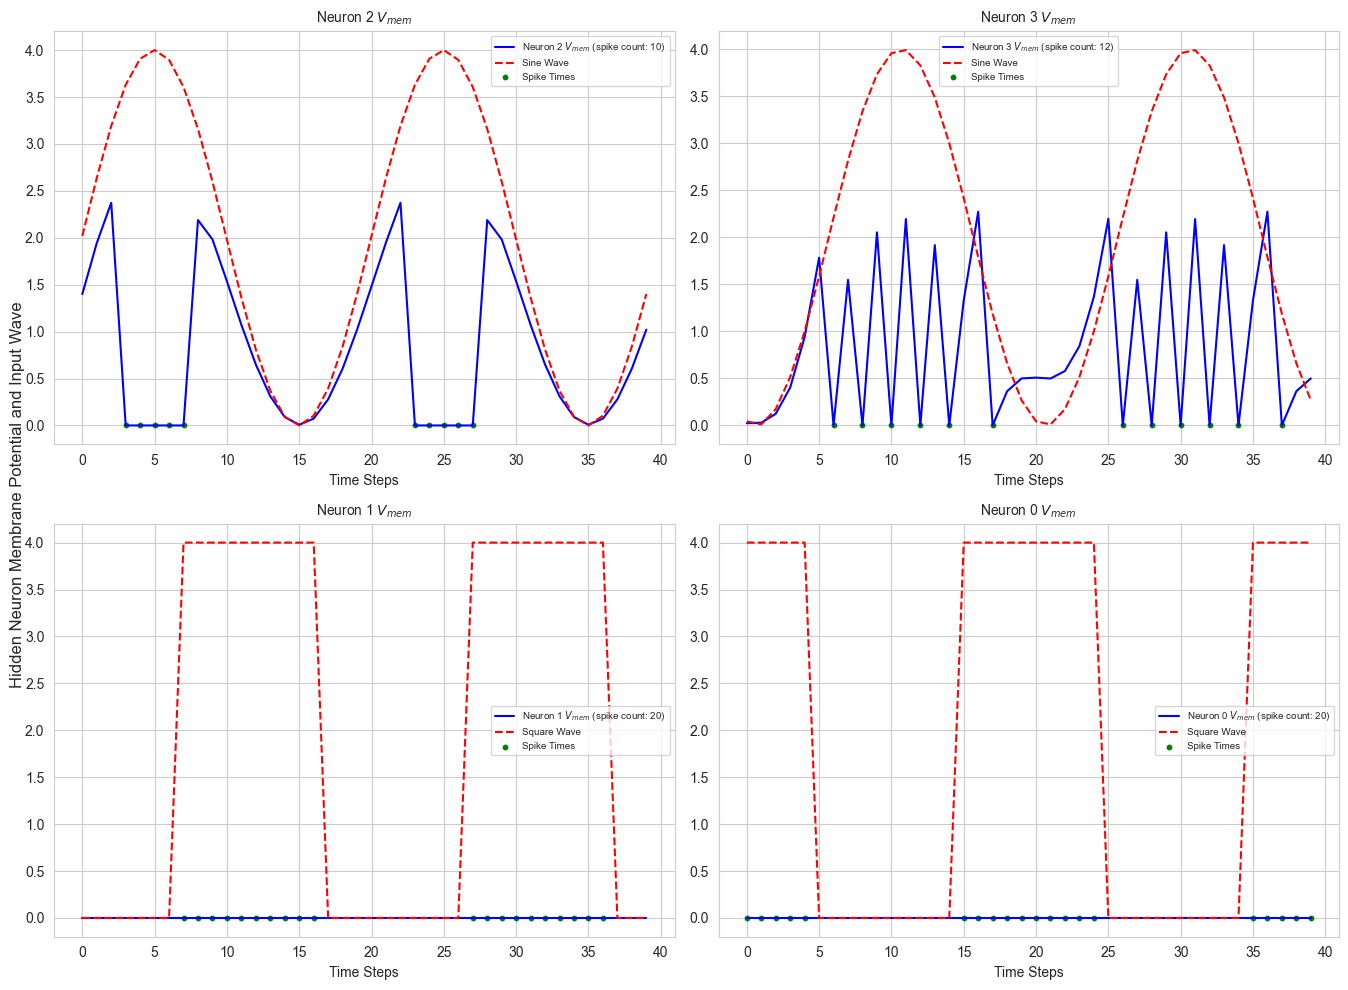

In [34]:
def plot_hidden_membrane_potentials(mem1_rec, spk1_rec, waves, hidden_neuron_indices, num_steps, labels, save_path=None):
    time_steps = np.arange(num_steps)
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    sine_wave_indices = [i for i, label in enumerate(labels) if label == 0]
    square_wave_indices = [i for i, label in enumerate(labels) if label == 1]

    selected_indices = random.sample(sine_wave_indices, 2) + random.sample(square_wave_indices, 2)

    for i, neuron_idx in enumerate(hidden_neuron_indices):
        hidden_mem_potential = mem1_rec[:, selected_indices[i], neuron_idx].detach().cpu().numpy()
        input_wave = waves[selected_indices[i]].cpu().numpy()  # Select corresponding wave
        spikes = spk1_rec[:, selected_indices[i], neuron_idx].detach().cpu().numpy()
        spike_times = np.where(spikes == 1)[0]
        spike_count = len(spike_times)

        row = i // 2
        col = i % 2

        axs[row, col].plot(time_steps, hidden_mem_potential, label=f'Neuron {neuron_idx} $V_{{mem}}$ (spike count: {spike_count})', color='blue')
        axs[row, col].plot(time_steps, input_wave, label=f'{"Sine" if labels[selected_indices[i]] == 0 else "Square"} Wave', color='red', linestyle='dashed')
        axs[row, col].scatter(spike_times, hidden_mem_potential[spike_times], color='green', s=10, label='Spike Times')
        axs[row, col].set_xlabel('Time Steps', fontsize=10)
        axs[row, col].set_title(f'Neuron {neuron_idx} $V_{{mem}}$', fontsize=10)
        axs[row, col].grid(True)
        axs[row, col].legend(fontsize=7)

    # Add a single y-axis label for the entire figure
    fig.text(0.04, 0.5, 'Hidden Neuron Membrane Potential and Input Wave', va='center', rotation='vertical', fontsize=12)

    plt.tight_layout(rect=[0.04, 0, 1, 1])  # Adjust layout to accommodate y-axis label
    if save_path:
        plt.savefig(save_path, dpi=1200)
    plt.show()
    plt.close()

# Plot hidden membrane potentials with spikes
hidden_neuron_indices = random.sample(range(hidden_size), 4)  # Adjust this list to choose specific neurons
waves, labels = next(iter(test_loader))
waves = waves.to(device).float()
labels = labels.to(device).long()
spk1_rec, mem1_rec, spk2_rec, mem2_rec, hidden_spike_count, output_spike_count = model(waves)
plot_hidden_membrane_potentials(mem1_rec, spk1_rec, waves, hidden_neuron_indices, num_steps, labels, save_path=os.path.join(unique_folder_name, 'hidden_membrane_potentials.png'))

In [35]:
# Function to plot output membrane potentials using Matplotlib
def plot_output_membrane_potentials_matplotlib(mem2_rec, spk2_rec, waves, num_steps, labels, save_path=None):
    sine_wave_indices = [i for i, label in enumerate(labels) if label == 0]
    square_wave_indices = [i for i, label in enumerate(labels) if label == 1]

    selected_sine_indices = random.sample(sine_wave_indices, 4)
    selected_square_indices = random.sample(square_wave_indices, 4)
    selected_indices = selected_sine_indices + selected_square_indices

    time_steps = np.arange(num_steps)
    fig, axs = plt.subplots(4, 2, figsize=(20, 20))  # Adjusted for a 4x2 grid of subplots

    for idx, wave_index in enumerate(selected_indices):
        row = idx // 2  # Integer division to get the row index
        col = idx % 2  # Modulus division to get the column index

        # Get the input wave (specified by wave_index)
        input_wave = waves[wave_index].cpu().numpy()

        # Plot for output neuron 0
        output_mem_potential_0 = mem2_rec[:, wave_index, 0].detach().cpu().numpy()
        spikes_0 = spk2_rec[:, wave_index, 0].detach().cpu().numpy()
        spike_times_0 = np.where(spikes_0 == 1)[0]
        spike_count_0 = len(spike_times_0)

        axs[row, col].plot(time_steps, output_mem_potential_0, label=f'Neuron 0 $V_{{mem}}$ (spike count: {spike_count_0})', color='blue')
        axs[row, col].scatter(spike_times_0, output_mem_potential_0[spike_times_0], color='black', s=10)

        # Plot for output neuron 1
        output_mem_potential_1 = mem2_rec[:, wave_index, 1].detach().cpu().numpy()
        spikes_1 = spk2_rec[:, wave_index, 1].detach().cpu().numpy()
        spike_times_1 = np.where(spikes_1 == 1)[0]
        spike_count_1 = len(spike_times_1)

        axs[row, col].plot(time_steps, output_mem_potential_1, label=f'Neuron 1 $V_{{mem}}$ (spike count: {spike_count_1})', color='orange')
        axs[row, col].scatter(spike_times_1, output_mem_potential_1[spike_times_1], color='red', s=10)

        axs[row, col].plot(time_steps, input_wave, label=f'{"Sine" if labels[wave_index] == 0 else "Square"} Wave', color='green', linestyle='dashed')
        axs[row, col].set_xlabel('Time Steps', fontsize=10)
        axs[row, col].set_title(f'index_{wave_index} {"Sine" if labels[wave_index] == 0 else "Square"} Wave and Output Layer Neurons $V_{{mem}}$', fontsize=10)
        axs[row, col].legend(fontsize=8)
        axs[row, col].grid(True)

        # Add vertical lines every 1 and 10 time steps
        for step in range(0, num_steps, 1):
            axs[row, col].axvline(x=step, color='lightgrey', linewidth=0.2)
        for step in range(0, num_steps, 10):
            axs[row, col].axvline(x=step, color='darkgrey', linewidth=0.5)

    # Add a single y-axis label for the entire figure
    fig.text(0.04, 0.5, 'Output Neuron Membrane Potential and Input Wave', va='center', rotation='vertical', fontsize=12)

    plt.tight_layout(rect=[0.04, 0, 1, 1])  # Adjust layout to accommodate y-axis label
    if save_path:
        plt.savefig(save_path, dpi=1200)
    plt.close()
# Function to plot output membrane potentials with spike counts
#plot_output_membrane_potentials_matplotlib(mem2_rec, spk2_rec, waves, num_steps, labels, save_path=os.path.join(unique_folder_name, 'output_membrane_potentials_4x2.png'))

In [36]:
# Function to plot output membrane potentials using Plotly
tau_output = -1000 * deltaT / np.log(model.lif2.beta.detach().cpu().numpy())

def plot_output_membrane_potentials_plotly(mem2_rec, spk2_rec, waves, num_steps, labels, tau_output, unique_folder_name):
    sine_wave_indices = [i for i, label in enumerate(labels) if label == 0]
    square_wave_indices = [i for i, label in enumerate(labels) if label == 1]

    selected_sine_indices = random.sample(sine_wave_indices, 4)
    selected_square_indices = random.sample(square_wave_indices, 4)
    selected_indices = selected_sine_indices + selected_square_indices

    time_steps = np.arange(num_steps)

    for idx, wave_index in enumerate(selected_indices):
        fig = go.Figure()

        # Get the input wave (specified by wave_index)
        input_wave = waves[wave_index].cpu().numpy()

        # Plot for output neuron 0
        output_mem_potential_0 = mem2_rec[:, wave_index, 0].detach().cpu().numpy()
        spikes_0 = spk2_rec[:, wave_index, 0].detach().cpu().numpy()
        spike_times_0 = np.where(spikes_0 == 1)[0]
        spike_count_0 = len(spike_times_0)

        fig.add_trace(go.Scatter(
            x=time_steps,
            y=output_mem_potential_0,
            mode='lines',
            name=f'Neuron 0 V_mem (spike count: {spike_count_0}, Tau: {tau_output[0]:.2f} ms)',
            line=dict(color='blue')
        ))

        fig.add_trace(go.Scatter(
            x=spike_times_0,
            y=output_mem_potential_0[spike_times_0],
            mode='markers',
            name='Neuron 0 spikes',
            marker=dict(color='black', size=10, symbol='circle')
        ))

        # Plot for output neuron 1
        output_mem_potential_1 = mem2_rec[:, wave_index, 1].detach().cpu().numpy()
        spikes_1 = spk2_rec[:, wave_index, 1].detach().cpu().numpy()
        spike_times_1 = np.where(spikes_1 == 1)[0]
        spike_count_1 = len(spike_times_1)

        fig.add_trace(go.Scatter(
            x=time_steps,
            y=output_mem_potential_1,
            mode='lines',
            name=f'Neuron 1 V_mem (spike count: {spike_count_1}, Tau: {tau_output[1]:.2f} ms)',
            line=dict(color='red')
        ))

        fig.add_trace(go.Scatter(
            x=spike_times_1,
            y=output_mem_potential_1[spike_times_1],
            mode='markers',
            name='Neuron 1 spikes',
            marker=dict(color='orange', size=10, symbol='circle')
        ))

        fig.add_trace(go.Scatter(
            x=time_steps,
            y=input_wave,
            mode='lines',
            name=f'{"Sine" if labels[wave_index] == 0 else "Square"} Wave',
            line=dict(color='green', dash='dash')
        ))

        fig.update_layout(
            title=f'Output Layer Neurons V_mem and Input Wave (index: {wave_index})',
            xaxis_title='Time Steps',
            yaxis_title='Membrane Potential',
            template='plotly_white'
        )

        fig.show()
        pio.write_html(fig, file=os.path.join(unique_folder_name, f'interactive_output_membrane_potentials_{idx}.html'))

# Example usage:
# Assume tau_output is defined and passed to the function
# tau_output = [tau_neuron_0, tau_neuron_1]
plot_output_membrane_potentials_plotly(mem2_rec, spk2_rec, waves, num_steps, labels, tau_output, unique_folder_name)

In [37]:
# Function to create and plot tables with tau values for hidden and output neurons
def plot_tau_values_tables(tau_hidden, tau_output, unique_folder_name):
    # Round tau values to 3 decimal points
    tau_hidden_rounded = [round(value, 3) for value in tau_hidden]
    tau_output_rounded = [round(value, 3) for value in tau_output]

    # Create dataframes for the tau values
    df_hidden = pd.DataFrame([tau_hidden_rounded], columns=[f'Neuron {i}' for i in range(len(tau_hidden_rounded))])
    df_output = pd.DataFrame([tau_output_rounded], columns=[f'Neuron {i}' for i in range(len(tau_output_rounded))])

    fig, axs = plt.subplots(2, 1, figsize=(14, 8))

    # Plot the hidden layer tau values table
    axs[0].axis('tight')
    axs[0].axis('off')
    table_hidden = axs[0].table(cellText=df_hidden.values,
                                colLabels=df_hidden.columns,
                                cellLoc='center',
                                loc='center')
    axs[0].set_title('Tau Values for Hidden Layer Neurons [ms]')

    # Plot the output layer tau values table
    axs[1].axis('tight')
    axs[1].axis('off')
    table_output = axs[1].table(cellText=df_output.values,
                                colLabels=df_output.columns,
                                cellLoc='center',
                                loc='center')
    axs[1].set_title('Tau Values for Output Layer Neurons [ms]')

    plt.tight_layout()
    plt.savefig(os.path.join(unique_folder_name, 'tau_values_tables.png'), dpi=600)
    plt.show()
    plt.close()
# Plot the tau values tables
#plot_tau_values_tables(tau_hidden, tau_output, unique_folder_name)

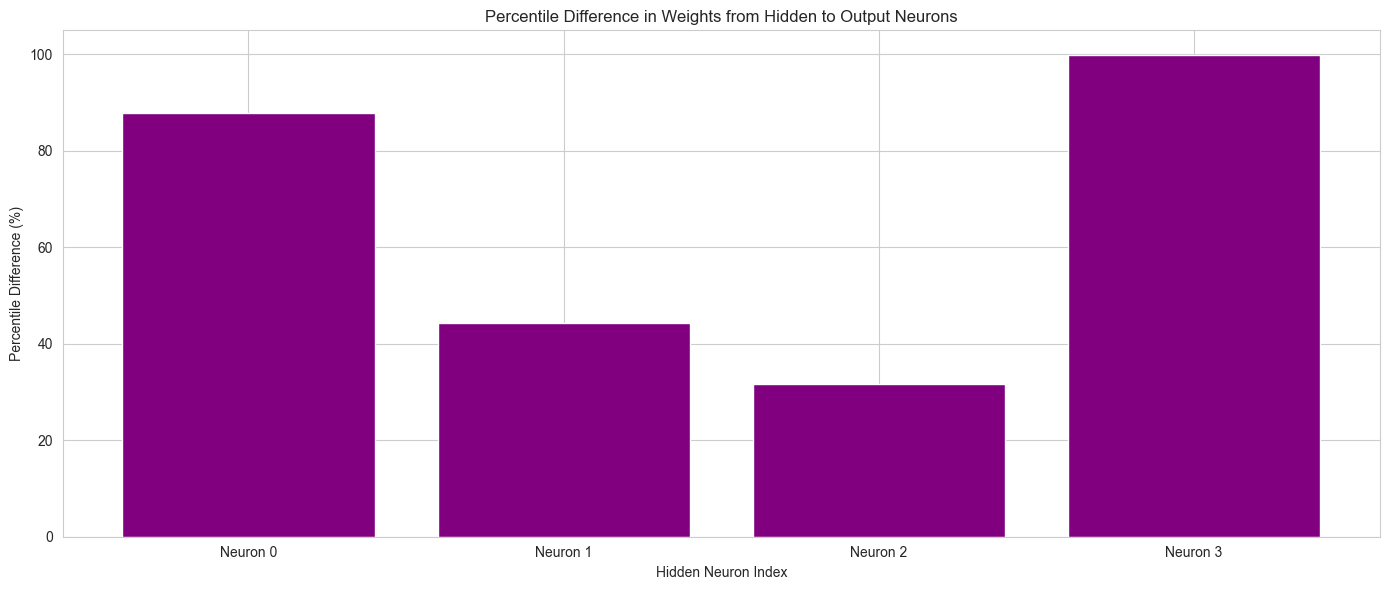

In [38]:
# Function to plot relative differences
def plot_relative_differences(weights_output_layer, unique_folder_name):
    weights_output_last = weights_output_layer[-1]
    relative_differences = []

    for i in range(weights_output_last.shape[1]):
        w1 = weights_output_last[0, i]
        w2 = weights_output_last[1, i]
        relative_diff = (np.abs(w1 - w2) / ((w1 + w2))) * 100
        relative_differences.append(relative_diff)

    plt.figure(figsize=(14, 6))
    plt.bar(np.arange(len(relative_differences)), relative_differences, color='purple')
    plt.xlabel('Hidden Neuron Index')
    plt.ylabel('Percentile Difference (%)')
    plt.title('Percentile Difference in Weights from Hidden to Output Neurons')
    plt.xticks(np.arange(len(relative_differences)), labels=[f'Neuron {i}' for i in range(len(relative_differences))])
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(unique_folder_name, 'relative_differences_hidden_to_output_weights.png'), dpi=600)
    plt.show()
    plt.close()
# Plot the relative differences
plot_relative_differences(weights_output_layer, unique_folder_name)

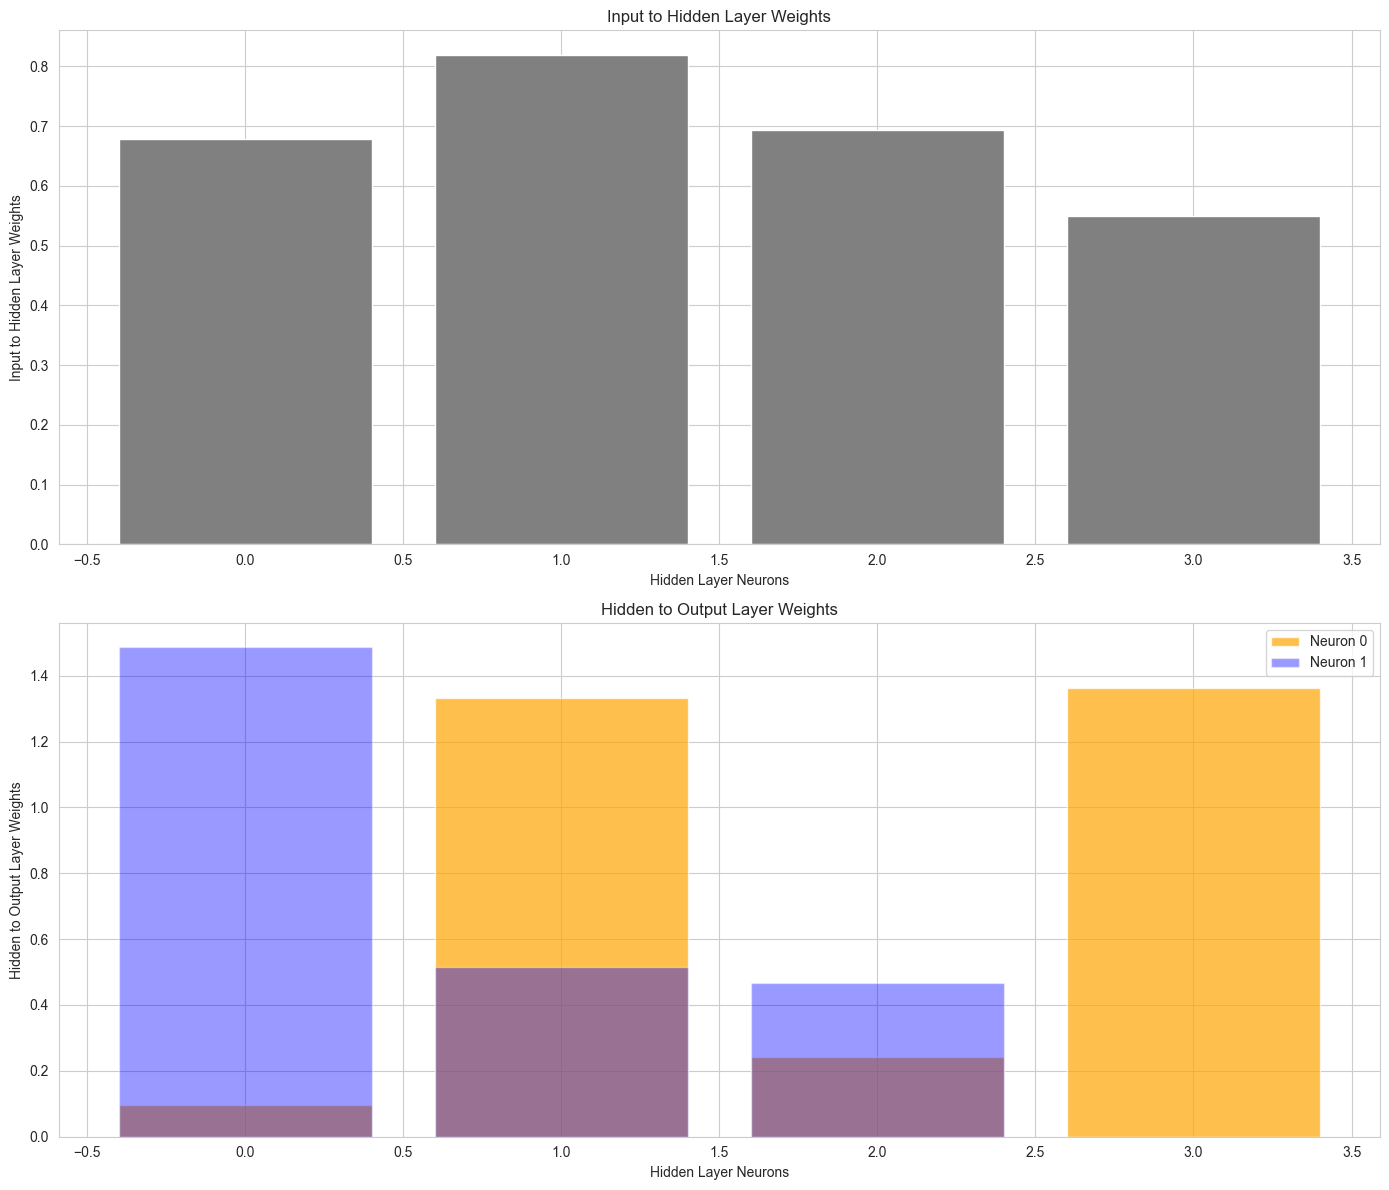

Weights from hidden to output neuron 0:
Hidden Neuron 0: 0.097
Hidden Neuron 1: 1.331
Hidden Neuron 2: 0.242
Hidden Neuron 3: 1.361

Weights from hidden to output neuron 1:
Hidden Neuron 0: 1.486
Hidden Neuron 1: 0.514
Hidden Neuron 2: 0.466
Hidden Neuron 3: 0.001


In [39]:
# Function to plot the weight comparisons using Matplotlib
def plot_weights_comparison(weights_hidden_layer, weights_output_layer, unique_folder_name):
    weights_hidden_layer_last = weights_hidden_layer[-1]
    weights_output_layer_last = weights_output_layer[-1]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

    # Plot input to hidden layer weights
    ax1.bar(np.arange(weights_hidden_layer_last.shape[0]), weights_hidden_layer_last.flatten(), color='gray')
    ax1.set_xlabel('Hidden Layer Neurons')
    ax1.set_ylabel('Input to Hidden Layer Weights')
    ax1.set_title('Input to Hidden Layer Weights')

    # Plot hidden to output layer weights
    ax2.bar(np.arange(weights_output_layer_last.shape[1]), weights_output_layer_last[0], color='orange', alpha=0.7, label='Neuron 0')
    ax2.bar(np.arange(weights_output_layer_last.shape[1]), weights_output_layer_last[1], color='blue', alpha=0.4, label='Neuron 1')
    ax2.set_xlabel('Hidden Layer Neurons')
    ax2.set_ylabel('Hidden to Output Layer Weights')
    ax2.set_title('Hidden to Output Layer Weights')
    ax2.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(unique_folder_name, 'weights_comparison.png'), dpi=600)
    plt.show()
    plt.close()

    # Print the weights
    print("Weights from hidden to output neuron 0:")
    for i, weight in enumerate(weights_output_layer_last[0]):
        if weight == 0:
            print(f"Hidden Neuron {i}: -")
        else:
            print(f"Hidden Neuron {i}: {weight:.3f}")

    print("\nWeights from hidden to output neuron 1:")
    for i, weight in enumerate(weights_output_layer_last[1]):
        if weight == 0:
            print(f"Hidden Neuron {i}: -")
        else:
            print(f"Hidden Neuron {i}: {weight:.3f}")
# Plot the weight comparisons
plot_weights_comparison(weights_hidden_layer, weights_output_layer, unique_folder_name)